# Data Load

Dataset used: Me Before You (Romance Book)


Corpus Size: Middle 2000 sentences extracted

Model: TinyLlama

Total Layers: 23

Layers Analyzed: Layer 14 (2/3rd), Layer 22 (Last)
- (ignore Layer 0 outputs)

Each results in a 2 048-dim vector, producing two matrices of shape (2 000 × 2 048).


# Outline

**Clustering Analysis**
- cosine similarity grouping
- DBSCAN
- K-means
- HDBSCAN
- Graph-based grouping


In [ ]:
pip install ebooklib beautifulsoup4 pdfminer.six nltk sentence-transformers scikit-learn numpy matplotlib tqdm pdfplumber

In [ ]:
import os
from ebooklib import epub
from bs4 import BeautifulSoup
import pdfminer.high_level

def extract_text_from_epub(filepath):
    book = epub.read_epub(filepath)
    text = []
    for item in book.get_items():
        if item.get_type() == 9:
            soup = BeautifulSoup(item.get_content(), "html.parser")
            text.append(soup.get_text())
    return "\n".join(text)

corpus_uncleaned = extract_text_from_epub("/content/book.epub")

/usr/local/lib/python3.11/dist-packages/ebooklib/epub.py:1395: UserWarning: In the future version we will turn default option ignore_ncx to True.
  warnings.warn('In the future version we will turn default option ignore_ncx to True.')
/usr/local/lib/python3.11/dist-packages/ebooklib/epub.py:1423: FutureWarning: This search incorrectly ignores the root element, and will be fixed in a future version.  If you rely on the current behaviour, change it to './/xmlns:rootfile[@media-type]'
  for root_file in tree.findall('//xmlns:rootfile[@media-type]', namespaces={'xmlns': NAMESPACES['CONTAINERNS']}):


In [ ]:
import re
def clean_text(text):
    text = re.sub(r"^\d{1,4}$", "", text, flags=re.MULTILINE)
    return text

In [ ]:
corpus = clean_text(corpus_uncleaned)

In [ ]:
with open("book_text.txt", "w", encoding="utf-8") as f:
    f.write(corpus)

print("cleaning completed. Saved as 'book_text.txt'.")

cleaning completed. Saved as 'book_text.txt'.


In [ ]:
import nltk
import json

nltk.download('punkt_tab')
from nltk.tokenize import sent_tokenize

sentences = sent_tokenize(corpus)

print(f"Total number of sentences: {len(sentences)}")

num_sentences_to_extract = 2000

if len(sentences) > num_sentences_to_extract:
    mid_index = len(sentences) // 2
    half_window = num_sentences_to_extract // 2
    # extract the middle 2000 sentences
    sentences = sentences[mid_index - half_window : mid_index + half_window]

# save to json
with open("book_sentences.json", "w", encoding="utf-8") as f:
    json.dump(sentences, f)

print(f"Saved extracted middle 2000 sentences as 'book_sentences.json'.")
print(f"Final number of sentences: {len(sentences)}")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Total number of sentences: 9241
Saved extracted middle 2000 sentences as 'book_sentences.json'.
Final number of sentences: 2000


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.corpus import stopwords

# Embedding model – TinyLlama
- tokenize each sentence, run the model, and return all hidden-state tensors.
- Extract last token vector from layer 15, 22

In [ ]:
print("Loading LLaMA model...")
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)

Loading LLaMA model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

Using device: cuda


In [ ]:
# tokenize text, run it through the model
def get_llama_token_embeddings(text, model, tokenizer, device):
    inputs = tokenizer(text, return_tensors="pt", max_length=256, truncation=True, padding=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    all_hidden_states = outputs.hidden_states
    last_hidden_state = all_hidden_states[-1]
    return tokens, all_hidden_states, last_hidden_state

In [ ]:
# extract the last token vector from a specific layer.
def get_last_token_vector(all_hidden_states, layer_idx):
    layer_output = all_hidden_states[layer_idx]
    last_token_vec = layer_output[:, -1, :].squeeze(0)
    return last_token_vec

In [ ]:
_, hidden_states, _ = get_llama_token_embeddings(sentences[0], model, tokenizer, device)
n_all = len(hidden_states)
print(f"Total hidden_states = {n_all} (including embedding inputs, etc.).")

# first, 15th layer, last layer
selected_layers = [0, 14, n_all-1]
print(f"Selected layers: {selected_layers}")

selected_layer_embeddings = {layer_idx: [] for layer_idx in selected_layers}

print("Extracting last-token embeddings for selected layers for each sentence...")
for text in tqdm(sentences):
    tokens, all_hidden_states, _ = get_llama_token_embeddings(text, model, tokenizer, device)
    for layer_idx in selected_layers:
        vec = get_last_token_vector(all_hidden_states, layer_idx)
        selected_layer_embeddings[layer_idx].append(vec)

for layer_idx in selected_layers:
    gpu_tensors = selected_layer_embeddings[layer_idx]
    selected_layer_embeddings[layer_idx] = np.array([tensor.cpu().numpy() if torch.is_tensor(tensor) else tensor for tensor in gpu_tensors])
    hidden_dim = selected_layer_embeddings[layer_idx].shape[1]
    print(f"Layer {layer_idx}: {selected_layer_embeddings[layer_idx].shape} (num_sentences: {selected_layer_embeddings[layer_idx].shape[0]}, hidden_dim: {hidden_dim})")
print(f"Selected layers processed: {len(selected_layers)}")

Total hidden_states = 23 (including embedding inputs, etc.).
Selected layers: [0, 14, 22]
Extracting last-token embeddings for selected layers for each sentence...


100%|██████████| 2000/2000 [01:11<00:00, 28.05it/s]


Layer 0: (2000, 2048) (num_sentences: 2000, hidden_dim: 2048)
Layer 14: (2000, 2048) (num_sentences: 2000, hidden_dim: 2048)
Layer 22: (2000, 2048) (num_sentences: 2000, hidden_dim: 2048)
Selected layers processed: 3


# Norm + Cosine Similarity

In [ ]:
#2 Norm + Cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
import numpy as np

# cosine similarity for each selected layer
sim_matrix_layers_normalized = []
sim_matrix_layers_non_normalized = []
avg_similarity_layers_normalized = []
avg_similarity_layers_non_normalized = []

print("Computing cosine similarity for each layer's sentence embeddings:")
for layer_idx in selected_layers:
    embeddings = selected_layer_embeddings[layer_idx]

    # non-normalized cosine similarity
    sim_matrix_non_normalized = cosine_similarity(embeddings)
    sim_matrix_layers_non_normalized.append(sim_matrix_non_normalized)

    # calculate average similarity for non-normalized version
    triu_indices_non_normalized = np.triu_indices_from(sim_matrix_non_normalized, k=1)
    avg_similarity_non_normalized = sim_matrix_non_normalized[triu_indices_non_normalized].mean()
    avg_similarity_layers_non_normalized.append(avg_similarity_non_normalized)

    # L2-normalization
    norm_embeddings = normalize(embeddings, norm='l2')

    # pairwise cosine similarity matrix on normalized embeddings
    sim_matrix_normalized = cosine_similarity(norm_embeddings)
    sim_matrix_layers_normalized.append(sim_matrix_normalized)

    # calculate average similarity for normalized version
    triu_indices_normalized = np.triu_indices_from(sim_matrix_normalized, k=1)
    avg_similarity_normalized = sim_matrix_normalized[triu_indices_normalized].mean()
    avg_similarity_layers_normalized.append(avg_similarity_normalized)

    print(f"\nLayer {layer_idx}:")
    print(f"  Non-Normalized Similarity Matrix Shape: {sim_matrix_non_normalized.shape}")
    print(f"  Non-Normalized Average Pairwise Cosine Similarity = {avg_similarity_non_normalized:.3f}")
    print(f"  Normalized Similarity Matrix Shape: {sim_matrix_normalized.shape}")
    print(f"  Normalized Average Pairwise Cosine Similarity = {avg_similarity_normalized:.3f}")

Computing cosine similarity for each layer's sentence embeddings:

Layer 0:
  Non-Normalized Similarity Matrix Shape: (2000, 2000)
  Non-Normalized Average Pairwise Cosine Similarity = 0.943
  Normalized Similarity Matrix Shape: (2000, 2000)
  Normalized Average Pairwise Cosine Similarity = 0.943

Layer 14:
  Non-Normalized Similarity Matrix Shape: (2000, 2000)
  Non-Normalized Average Pairwise Cosine Similarity = 0.481
  Normalized Similarity Matrix Shape: (2000, 2000)
  Normalized Average Pairwise Cosine Similarity = 0.481

Layer 22:
  Non-Normalized Similarity Matrix Shape: (2000, 2000)
  Non-Normalized Average Pairwise Cosine Similarity = 0.785
  Normalized Similarity Matrix Shape: (2000, 2000)
  Normalized Average Pairwise Cosine Similarity = 0.785


Plotting frequency distributions for each layer's normalized similarity matrix:


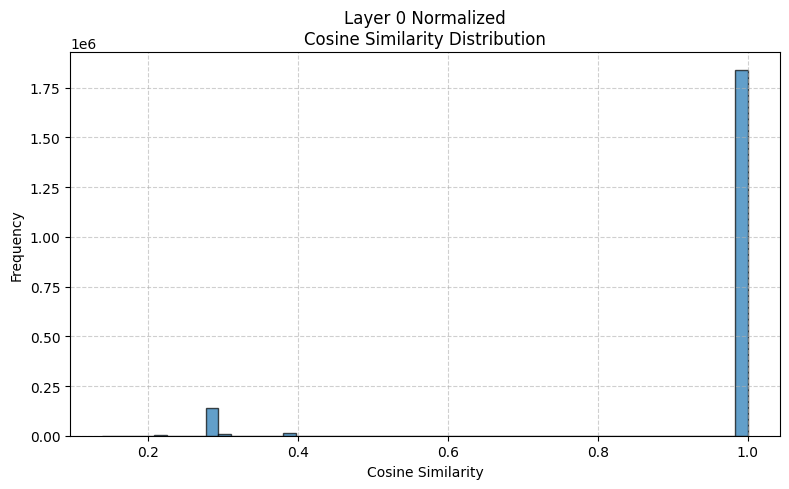


Layer 0 Normalized Similarity Statistics:
  Mean: 0.9425
  Median: 1.0000
  Standard Deviation: 0.1938
  Min: 0.1391
  Max: 1.0000


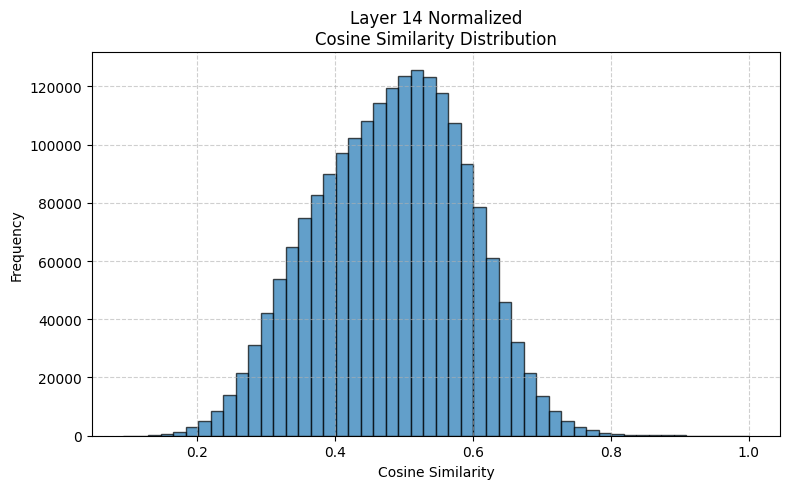


Layer 14 Normalized Similarity Statistics:
  Mean: 0.4812
  Median: 0.4868
  Standard Deviation: 0.1083
  Min: 0.0928
  Max: 1.0000


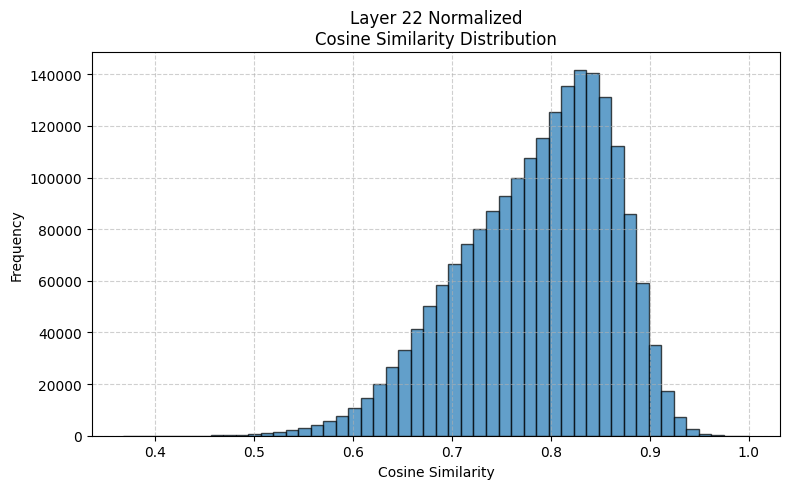


Layer 22 Normalized Similarity Statistics:
  Mean: 0.7852
  Median: 0.7971
  Standard Deviation: 0.0763
  Min: 0.3677
  Max: 1.0000


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

print("Plotting frequency distributions for each layer's normalized similarity matrix:")

for i, layer_idx in enumerate(selected_layers):
    sim_matrix_normalized = sim_matrix_layers_normalized[i]

    triu_indices_normalized = np.triu_indices_from(sim_matrix_normalized, k=1)
    sim_values_normalized = sim_matrix_normalized[triu_indices_normalized]

    plt.figure(figsize=(8, 5))
    plt.hist(sim_values_normalized, bins=50, edgecolor='black', alpha=0.7)
    plt.title(f"Layer {layer_idx} Normalized\nCosine Similarity Distribution")
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

    print(f"\nLayer {layer_idx} Normalized Similarity Statistics:")
    print(f"  Mean: {np.mean(sim_values_normalized):.4f}")
    print(f"  Median: {np.median(sim_values_normalized):.4f}")
    print(f"  Standard Deviation: {np.std(sim_values_normalized):.4f}")
    print(f"  Min: {np.min(sim_values_normalized):.4f}")
    print(f"  Max: {np.max(sim_values_normalized):.4f}")

Layer 0
- extremely skewed distribution. mean: 0.94
- Most similarities are clustered near 1.0
- very little variation in embeddings
- suggests that initial token embeddings are very similar
- Likely captures basic lexical/surface-level similarities

Layer 14 (Middle Layer):

Bell-shaped (normal) distribution
- Mean: 0.4812
- Much wider spread of similarities
- Centered around 0.4-0.5
- Indicates more nuanced, diverse representations
- Suggests the model is learning more complex, discriminative features
- Representations become less trivially similar

Layer 22 (Final Layer):

- Shifted bell-shaped distribution
- Mean: 0.7852
- Higher central tendency compared to Layer 14
- More concentrated around 0.7-0.9
- Suggests the model has learned more coherent, task-relevant representations
- Captures higher-level semantic similarities
- Representations are more aligned but not as trivially similar as Layer 0


Layer 0: Basic, almost identical representations
Layer 14: Diverse, discriminative features
Layer 22: Coherent, semantically meaningful representations

deep neural networks progressively extract more abstract and meaningful features through successive layers.



### **DBSCAN**

In [ ]:
pip install kneed

In [ ]:
from sklearn.cluster import DBSCAN

def clustering_grouping(embedding, thres):
  eps = 1 - thres
  clustering = DBSCAN(eps=eps, min_samples=2, metric="cosine").fit(embedding)
  labels = clustering.labels_

  groups = {}
  for idx, label in enumerate(labels):
    if label not in groups:
      groups[label] = []
    groups[label].append(idx)
  return list(groups.values())

In [ ]:
# first layer (layer 0)
dbscan_first_layer = clustering_grouping(selected_layer_embeddings[selected_layers[0]], 0.9)

# middle layer (layer 14)
dbscan_middle_layer = clustering_grouping(selected_layer_embeddings[selected_layers[1]], 0.9)

# last layer (layer 22)
dbscan_last_layer = clustering_grouping(selected_layer_embeddings[selected_layers[2]], 0.9)

print(f"First layer (Layer {selected_layers[0]}):")
print(f"Number of clusters: {len(dbscan_first_layer)}")

print(f"\nMiddle layer (Layer {selected_layers[1]}):")
print(f"Number of clusters: {len(dbscan_middle_layer)}")

print(f"\nLast layer (Layer {selected_layers[2]}):")
print(f"Number of clusters: {len(dbscan_last_layer)}")

First layer (Layer 0):
Number of clusters: 5

Middle layer (Layer 14):
Number of clusters: 29

Last layer (Layer 22):
Number of clusters: 30


In [ ]:
import numpy as np

# count sentences in each cluster and sort
def count_sentences_per_cluster_dbscan(clusters):
    counts = [len(cluster) for cluster in clusters]
    return np.array(sorted(counts, reverse=True))

# count sentences per cluster for each layer
vector_sent_dbscan_first = count_sentences_per_cluster_dbscan(dbscan_first_layer)
vector_sent_dbscan_middle = count_sentences_per_cluster_dbscan(dbscan_middle_layer)
vector_sent_dbscan_last = count_sentences_per_cluster_dbscan(dbscan_last_layer)

print("First layer sentence counts (sorted):")
print(vector_sent_dbscan_first)

print("\nMiddle layer sentence counts (sorted):")
print(vector_sent_dbscan_middle)

print("\nLast layer sentence counts (sorted):")
print(vector_sent_dbscan_last)


First layer sentence counts (sorted):
[1916   72    6    5    1]

Middle layer sentence counts (sorted):
[1916   25    4    4    3    2    2    2    2    2    2    2    2    2
    2    2    2    2    2    2    2    2    2    2    2    2    2    2
    2]

Last layer sentence counts (sorted):
[1521  406    7    5    4    4    3    3    3    3    3    2    2    2
    2    2    2    2    2    2    2    2    2    2    2    2    2    2
    2    2]


### **KMEANS**

In [ ]:
pip install kneed

Using random k values: [220, 271, 287, 299, 302, 302, 306, 321, 330, 349, 351, 388, 391, 414, 457, 470, 493, 508, 530, 543, 548, 559, 572, 585, 613, 635, 643, 658, 666, 691]

=== K-Means Clustering for Layer 14 (using 30 random k values from 200-600) ===
  Computing K-Means with k=220...
    k=220, WCSS=589.60
  Computing K-Means with k=271...
    k=271, WCSS=558.27
  Computing K-Means with k=287...
    k=287, WCSS=550.19
  Computing K-Means with k=299...
    k=299, WCSS=543.47
  Computing K-Means with k=302...
    k=302, WCSS=542.00
  Computing K-Means with k=302...
    k=302, WCSS=542.00
  Computing K-Means with k=306...
    k=306, WCSS=539.79
  Computing K-Means with k=321...
    k=321, WCSS=532.28
  Computing K-Means with k=330...
    k=330, WCSS=528.07
  Computing K-Means with k=349...
    k=349, WCSS=517.99
  Computing K-Means with k=351...
    k=351, WCSS=516.81
  Computing K-Means with k=388...
    k=388, WCSS=498.28
  Computing K-Means with k=391...
    k=391, WCSS=496.66
  Co

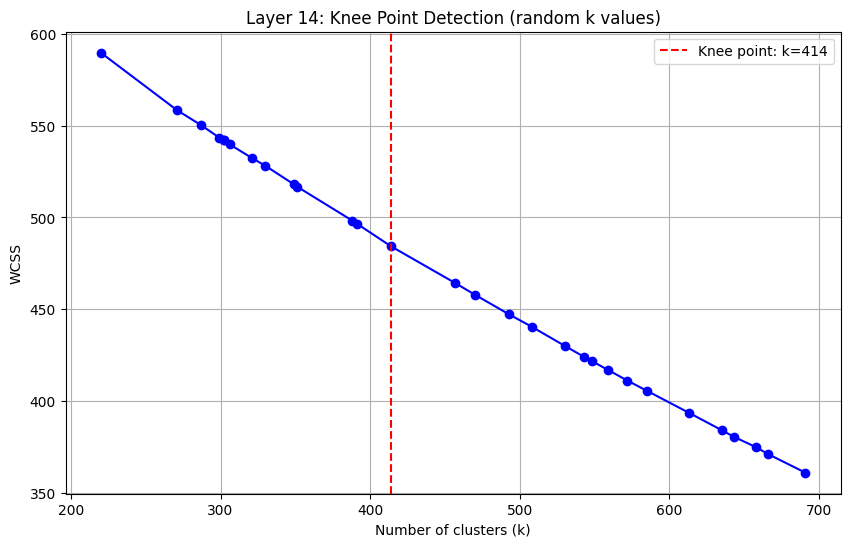


=== K-Means Clustering for Layer 22 (using 30 random k values from 200-600) ===
  Computing K-Means with k=220...
    k=220, WCSS=208.91
  Computing K-Means with k=271...
    k=271, WCSS=197.57
  Computing K-Means with k=287...
    k=287, WCSS=194.11
  Computing K-Means with k=299...
    k=299, WCSS=191.61
  Computing K-Means with k=302...
    k=302, WCSS=191.04
  Computing K-Means with k=302...
    k=302, WCSS=191.04
  Computing K-Means with k=306...
    k=306, WCSS=190.07
  Computing K-Means with k=321...
    k=321, WCSS=186.49
  Computing K-Means with k=330...
    k=330, WCSS=184.38
  Computing K-Means with k=349...
    k=349, WCSS=180.08
  Computing K-Means with k=351...
    k=351, WCSS=179.84
  Computing K-Means with k=388...
    k=388, WCSS=172.22
  Computing K-Means with k=391...
    k=391, WCSS=171.65
  Computing K-Means with k=414...
    k=414, WCSS=166.61
  Computing K-Means with k=457...
    k=457, WCSS=158.91
  Computing K-Means with k=470...
    k=470, WCSS=156.55
  Compu

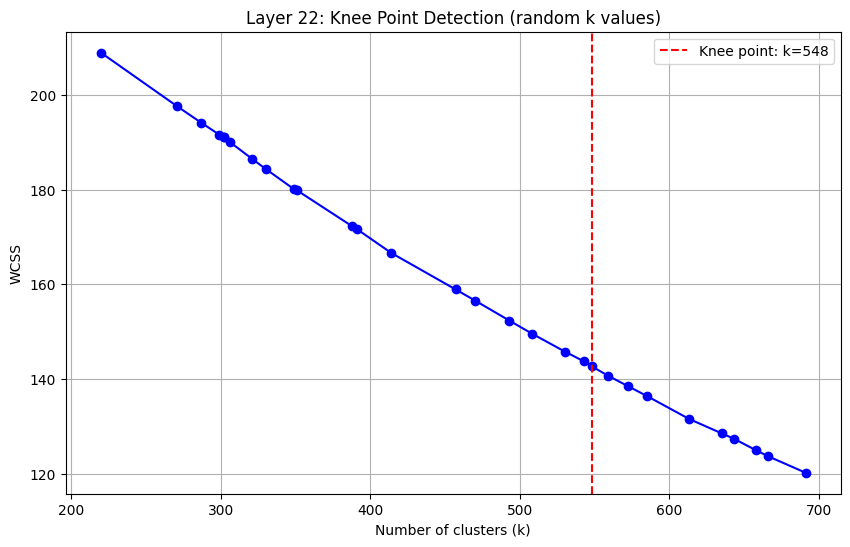


=== Summary of Optimal k Values ===
Layer 14: Optimal k = 414
Layer 22: Optimal k = 548


In [ ]:
from kneed import KneeLocator

np.random.seed(42)
k_values = sorted(np.random.randint(200, 700, size=30).tolist())
print(f"Using random k values: {k_values}")

target_layers = [14, 22]
kmeans_results = {}

for target_layer in target_layers:
    print(f"\n=== K-Means Clustering for Layer {target_layer} (using 30 random k values from 200-600) ===")

    layer_emb = selected_layer_embeddings[target_layer]

    # normalize embeddings
    layer_emb_norm = normalize(layer_emb, norm='l2')

    wcss_values = []

    for k in k_values:
        print(f"  Computing K-Means with k={k}...")
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=1)
        kmeans.fit(layer_emb_norm)
        wcss_values.append(kmeans.inertia_)
        print(f"    k={k}, WCSS={kmeans.inertia_:.2f}")

    try:
        kneedle = KneeLocator(k_values, wcss_values, curve='convex', direction='decreasing', online=True)
        knee_k = kneedle.knee

        if knee_k is None:
            print(f"Layer {target_layer}: No clear knee point found.")
            best_k = k_values[len(k_values) // 2]
        else:
            best_k = knee_k
            print(f"Layer {target_layer}: Knee point at k={best_k}, WCSS={wcss_values[k_values.index(best_k)]:.3f}")

        best_kmeans = KMeans(n_clusters=best_k, random_state=42)
        best_kmeans.fit(layer_emb_norm)
        best_labels = best_kmeans.labels_

    except Exception as e:
        print(f"Error in knee detection: {e}")
        best_k = k_values[len(k_values) // 2]
        print(f"Layer {target_layer}: Using default k={best_k}")
        best_kmeans = KMeans(n_clusters=best_k, random_state=42)
        best_kmeans.fit(layer_emb_norm)
        best_labels = best_kmeans.labels_

    kmeans_results[target_layer] = (best_k, best_kmeans, best_labels, wcss_values)

    # plot WCSS curve
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, wcss_values, 'bo-')
    plt.axvline(x=best_k, color='r', linestyle='--', label=f'Knee point: k={best_k}')
    plt.title(f'Layer {target_layer}: Knee Point Detection (random k values)')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('WCSS')
    plt.legend()
    plt.grid(True)
    plt.show()

print("\n=== Summary of Optimal k Values ===")
for layer_idx, (best_k, _, _, _) in kmeans_results.items():
    print(f"Layer {layer_idx}: Optimal k = {best_k}")


In [ ]:
kmeans_first_layer = KMeans(n_clusters=390, random_state=42)
kmeans_middle_layer = KMeans(n_clusters=414, random_state=42)
kmeans_last_layer = KMeans(n_clusters=548, random_state=42)

# get embeddings for each layer
first_layer_embeddings = selected_layer_embeddings[selected_layers[0]]  # Layer 0
middle_layer_embeddings = selected_layer_embeddings[selected_layers[1]]  # Layer 14
last_layer_embeddings = selected_layer_embeddings[selected_layers[2]]    # Layer 22

# fit K-means to the raw embeddings
first_layer_labels = kmeans_first_layer.fit_predict(first_layer_embeddings)
middle_layer_labels = kmeans_middle_layer.fit_predict(middle_layer_embeddings)
last_layer_labels = kmeans_last_layer.fit_predict(last_layer_embeddings)


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (390). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


In [ ]:
def count_sentences_per_cluster(cluster_labels):
    unique, counts = np.unique(cluster_labels, return_counts=True)
    return counts

sentences_per_cluster_first = count_sentences_per_cluster(first_layer_labels)
sentences_per_cluster_middle = count_sentences_per_cluster(middle_layer_labels)
sentences_per_cluster_last = count_sentences_per_cluster(last_layer_labels)

# sentence count stored in vector
import numpy as np

vector_sent_kmeans_first = np.array(sorted(sentences_per_cluster_first, reverse=True))
vector_sent_kmeans_mid = np.array(sorted(sentences_per_cluster_middle, reverse=True))
vector_sent_kmeans_last = np.array(sorted(sentences_per_cluster_last, reverse=True))

print("First layer sentence counts (sorted):")
print(vector_sent_kmeans_first)

print("\nMiddle layer sentence counts (sorted):")
print(vector_sent_kmeans_mid)

print("\nLast layer sentence counts (sorted):")
print(vector_sent_kmeans_last)

First layer sentence counts (sorted):
[1916   72    6    5    1]

Middle layer sentence counts (sorted):
[26 24 22 22 19 19 18 18 17 17 17 17 16 16 16 16 16 15 14 14 14 14 14 13
 13 13 13 13 13 13 13 12 12 12 12 11 11 11 11 11 11 11 10 10 10 10 10 10
 10 10 10 10 10 10 10 10  9  9  9  9  9  9  9  9  9  9  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2 

### **Cosine Similarity Grouping**

In [ ]:

def grouping(cos_similar, n, thres):
  groups = []
  visited = set()

  for i in range(n):
    if i in visited:
      continue

    group = [i]
    visited.add(i)

    for j in range(i+1, n):
      if cos_similar[i][j] >= thres:
        group.append(j)
        visited.add(j)

    groups.append(group)

  return groups

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def compute_cosine_similarity(embeddings):
    return cosine_similarity(embeddings)

thres = 0.9

#first layer (layer 0)
first_layer_embeddings = selected_layer_embeddings[selected_layers[0]]
first_layer_similarity = compute_cosine_similarity(first_layer_embeddings)
first_layer_groups = grouping(first_layer_similarity, len(first_layer_embeddings), thres)
print(f"First layer (Layer {selected_layers[0]}):")
print(f"Number of groups: {len(first_layer_groups)}")
print(f"Group sizes: {sorted([len(group) for group in first_layer_groups], reverse=True)}")

#middle layer (layer 14)
middle_layer_embeddings = selected_layer_embeddings[selected_layers[1]]
middle_layer_similarity = compute_cosine_similarity(middle_layer_embeddings)
middle_layer_groups = grouping(middle_layer_similarity, len(middle_layer_embeddings), thres)
print(f"\nMiddle layer (Layer {selected_layers[1]}):")
print(f"Number of groups: {len(middle_layer_groups)}")
print(f"Group sizes: {sorted([len(group) for group in middle_layer_groups], reverse=True)}")

#last layer (layer 22)
last_layer_embeddings = selected_layer_embeddings[selected_layers[2]]
last_layer_similarity = compute_cosine_similarity(last_layer_embeddings)
last_layer_groups = grouping(last_layer_similarity, len(last_layer_embeddings), thres)
print(f"\nLast layer (Layer {selected_layers[2]}):")
print(f"Number of groups: {len(last_layer_groups)}")
print(f"Group sizes: {sorted([len(group) for group in last_layer_groups], reverse=True)}")

First layer (Layer 0):
Number of groups: 5
Group sizes: [1916, 72, 6, 5, 1]

Middle layer (Layer 14):
Number of groups: 1952
Group sizes: [11, 6, 5, 4, 4, 4, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
import numpy as np
# extract sorted counts of sentences per cluster
def count_sentences_per_cluster_grouping(groups):
    counts = [len(group) for group in groups]
    return np.array(sorted(counts, reverse=True))

# count sentences per cluster for each layer
vector_sent_grouping_first = count_sentences_per_cluster_grouping(first_layer_groups)
vector_sent_grouping_middle = count_sentences_per_cluster_grouping(middle_layer_groups)
vector_sent_grouping_last = count_sentences_per_cluster_grouping(last_layer_groups)

print("First layer sentence counts (sorted):")
print(vector_sent_grouping_first)

print("\nMiddle layer sentence counts (sorted):")
print(vector_sent_grouping_middle)

print("\nLast layer sentence counts (sorted):")
print(vector_sent_grouping_last)


First layer sentence counts (sorted):
[1916   72    6    5    1]

Middle layer sentence counts (sorted):
[11  6  5 ...  1  1  1]

Last layer sentence counts (sorted):
[245 144 143 128  98  92  90  84  84  83  79  71  63  58  57  57  55  55
  54  53  53  51  41  41  39  39  39  37  37  35  35  35  33  33  33  33
  32  32  29  29  29  29  29  28  27  27  27  26  25  24  24  24  24  23
  23  23  23  22  22  22  20  20  19  19  19  18  18  17  17  17  16  16
  16  16  16  16  15  15  15  14  14  14  14  13  13  13  12  12  12  12
  12  12  12  12  11  11  11  11  11  11  11  10  10  10  10  10  10  10
  10   9   9   9   9   9   9   9   9   9   9   9   8   8   8   8   8   8
   8   8   8   8   8   8   7   7   7   7   7   7   7   7   7   7   6   6
   6   6   6   6   6   6   6   6   6   6   6   6   5   5   5   5   5   5
   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5
   5   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4
   4   4   4   4   4   4   4  

# Graph-based Grouping (connected componenets) - clustering

In [ ]:
# graph-based grouping (connected componenets) - clustering
import networkx as nx

def graph_based_grouping(cos_similar, n, thres):
  graph = nx.Graph()

  graph.add_nodes_from(range(n))

  for i in range(n):
    for j in range(i+1, n):
      if cos_similar[i][j] >= thres:
        graph.add_edge(i, j)

  groups = [list(component) for component in nx.connected_components(graph)]

  return groups

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

def graph_based_grouping(cos_similar, n, thres):
  graph = nx.Graph()
  graph.add_nodes_from(range(n))

  for i in range(n):
    for j in range(i+1, n):
      if cos_similar[i][j] >= thres:
        graph.add_edge(i, j)

  groups = [list(component) for component in nx.connected_components(graph)]
  return groups

def count_sentences_per_cluster_graph(groups):
    counts = [len(group) for group in groups]
    return np.array(sorted(counts, reverse=True))

thres = 0.85


In [ ]:
# first layer (layer 0)
first_layer_embeddings = selected_layer_embeddings[selected_layers[0]]
first_layer_similarity = cosine_similarity(first_layer_embeddings)
first_layer_graph_groups = graph_based_grouping(first_layer_similarity, len(first_layer_embeddings), thres)
print(f"First layer (Layer {selected_layers[0]}) - Graph-based grouping:")
print(f"Number of groups: {len(first_layer_graph_groups)}")
print(f"Group sizes: {sorted([len(group) for group in first_layer_graph_groups], reverse=True)}")

# middle layer (layer 14)
middle_layer_embeddings = selected_layer_embeddings[selected_layers[1]]
middle_layer_similarity = cosine_similarity(middle_layer_embeddings)
middle_layer_graph_groups = graph_based_grouping(middle_layer_similarity, len(middle_layer_embeddings), thres)
print(f"\nMiddle layer (Layer {selected_layers[1]}) - Graph-based grouping:")
print(f"Number of groups: {len(middle_layer_graph_groups)}")
print(f"Group sizes: {sorted([len(group) for group in middle_layer_graph_groups], reverse=True)}")

# last layer (layer 22)
last_layer_embeddings = selected_layer_embeddings[selected_layers[2]]
last_layer_similarity = cosine_similarity(last_layer_embeddings)
last_layer_graph_groups = graph_based_grouping(last_layer_similarity, len(last_layer_embeddings), thres)
print(f"\nLast layer (Layer {selected_layers[2]}) - Graph-based grouping:")
print(f"Number of groups: {len(last_layer_graph_groups)}")
print(f"Group sizes: {sorted([len(group) for group in last_layer_graph_groups], reverse=True)}")

# count sentences per cluster for each layer
vector_sent_graph_first = count_sentences_per_cluster_graph(first_layer_graph_groups)
vector_sent_graph_middle = count_sentences_per_cluster_graph(middle_layer_graph_groups)
vector_sent_graph_last = count_sentences_per_cluster_graph(last_layer_graph_groups)

print("\nFirst layer sentence counts (sorted) - Graph-based:")
print(vector_sent_graph_first)

print("\nMiddle layer sentence counts (sorted) - Graph-based:")
print(vector_sent_graph_middle)

print("\nLast layer sentence counts (sorted) - Graph-based:")
print(vector_sent_graph_last)

print("\n--- Comparison with Original Grouping Method ---")
print(f"First layer: {len(first_layer_groups)} groups (original) vs {len(first_layer_graph_groups)} groups (graph-based)")
print(f"Middle layer: {len(middle_layer_groups)} groups (original) vs {len(middle_layer_graph_groups)} groups (graph-based)")
print(f"Last layer: {len(last_layer_groups)} groups (original) vs {len(last_layer_graph_groups)} groups (graph-based)")

First layer (Layer 0) - Graph-based grouping:
Number of groups: 5
Group sizes: [1916, 72, 6, 5, 1]

Middle layer (Layer 14) - Graph-based grouping:
Number of groups: 1826
Group sizes: [68, 10, 7, 7, 7, 5, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

# HDBSCAN


In [ ]:
import random
from functools import partial
import hdbscan
import umap
import tensorflow as tf
import tensorflow_hub as hub
from sentence_transformers import SentenceTransformer
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
from tqdm.notebook import trange
from hyperopt import fmin, tpe, hp, STATUS_OK, space_eval, Trials

def hdbscan_clusters(message_embeddings,
                      n_neighbors,
                      n_components,
                      min_cluster_size,
                      min_samples = None,
                      random_state = None):

    umap_embeddings = (umap.UMAP(n_neighbors = n_neighbors,
                                n_components = n_components,
                                metric = 'cosine',
                                random_state=random_state)
                            .fit_transform(message_embeddings))

    clusters = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size,
                               min_samples = min_samples,
                               metric='euclidean',
                               gen_min_span_tree=True,
                               cluster_selection_method='eom').fit(umap_embeddings)

    return clusters

In [ ]:
import numpy as np
from sklearn.preprocessing import normalize

# Layer 0
clusters0 = hdbscan_clusters(
    normalize(selected_layer_embeddings[0], norm='l2'),
    n_neighbors=10,
    n_components=2,
    min_cluster_size=5,
    random_state=42
)
labels_hdbscan0 = clusters0.labels_
num_clusters0 = len(set(labels_hdbscan0)) - (1 if -1 in labels_hdbscan0 else 0)
print(f"Layer 0: {num_clusters0} clusters")

# Layer 14
clusters14 = hdbscan_clusters(
    normalize(selected_layer_embeddings[14], norm='l2'),
    n_neighbors=30,
    n_components=20,
    min_cluster_size=2,
    random_state=42
)
labels_hdbscan14 = clusters14.labels_
num_clusters14 = len(set(labels_hdbscan14)) - (1 if -1 in labels_hdbscan14 else 0)
print(f"Layer 14: {num_clusters14} clusters")

# Layer 22
clusters22 = hdbscan_clusters(
    normalize(selected_layer_embeddings[22], norm='l2'),
    n_neighbors=30,
    n_components=20,
    min_cluster_size=2,
    random_state=42
)
labels_hdbscan22 = clusters22.labels_
num_clusters22 = len(set(labels_hdbscan22)) - (1 if -1 in labels_hdbscan22 else 0)
print(f"Layer 22: {num_clusters22} clusters")

# Function to count sentences per cluster
def count_sentences_per_hdbscan_cluster(cluster_labels):
    num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    counts = np.zeros(num_clusters, dtype=int)

    for label in cluster_labels:
        if label != -1:  # Skip noise points
            counts[label] += 1

    return counts

# Count sentences per cluster for each layer
sentence_counts_hdbscan_layer0 = count_sentences_per_hdbscan_cluster(labels_hdbscan0)
sentence_counts_hdbscan_layer14 = count_sentences_per_hdbscan_cluster(labels_hdbscan14)
sentence_counts_hdbscan_layer22 = count_sentences_per_hdbscan_cluster(labels_hdbscan22)

# Vectorize and sort the counts in descending order
vector_sent_hdbscan_layer0 = np.array(sorted(sentence_counts_hdbscan_layer0, reverse=True))
vector_sent_hdbscan_layer14 = np.array(sorted(sentence_counts_hdbscan_layer14, reverse=True))
vector_sent_hdbscan_layer22 = np.array(sorted(sentence_counts_hdbscan_layer22, reverse=True))

# Print the distribution of sentences across clusters
print("\n=== Distribution of sentences across clusters ===")

print(f"\nLayer 0 ({num_clusters0} clusters):")
print(f"Total sentences in clusters: {np.sum(vector_sent_hdbscan_layer0)}")
print(f"Noise points: {np.sum(labels_hdbscan0 == -1)}")
print(f"Top 5 clusters: {vector_sent_hdbscan_layer0[:5]}")
print(f"Sentence distribution: {vector_sent_hdbscan_layer0}")

print(f"\nLayer 14 ({num_clusters14} clusters):")
print(f"Total sentences in clusters: {np.sum(vector_sent_hdbscan_layer14)}")
print(f"Noise points: {np.sum(labels_hdbscan14 == -1)}")
print(f"Top 5 clusters: {vector_sent_hdbscan_layer14[:5]}")
print(f"Sentence distribution: {vector_sent_hdbscan_layer14}")

print(f"\nLayer 22 ({num_clusters22} clusters):")
print(f"Total sentences in clusters: {np.sum(vector_sent_hdbscan_layer22)}")
print(f"Noise points: {np.sum(labels_hdbscan22 == -1)}")
print(f"Top 5 clusters: {vector_sent_hdbscan_layer22[:5]}")
print(f"Sentence distribution: {vector_sent_hdbscan_layer22}")



=== Generating clusters with optimal parameters ===


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:

Layer 0: 2 clusters


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Layer 14: 202 clusters
Layer 22: 4 clusters

=== Distribution of sentences across clusters ===

Layer 0 (2 clusters):
Total sentences in clusters: 2000
Noise points: 0
Top 5 clusters: [1923   77]
Sentence distribution: [1923   77]

Layer 14 (202 clusters):
Total sentences in clusters: 1373
Noise points: 627
Top 5 clusters: [253  67  37  31  23]
Sentence distribution: [253  67  37  31  23  20  20  16  15  13  13  13  12  12  12  11  11  11
  11  11  11  10  10  10  10  10  10   9   9   9   9   9   8   8   8   7
   7   7   7   7   7   6   6   6   6   6   6   6   6   6   6   6   6   6
   6   6   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5
   5   5   5   5   5   5   5   4   4   4   4   4   4   4   4   4   4   4
   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4
   4   4   4   4   4   4   4   3   3   3   3   3   3   3   3   3   3   3
   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3
   3   3   3   3   3   3   3   3   3   3   3  

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


# Plot

Saved plot: cluster_plots/first_dbscan_book.png


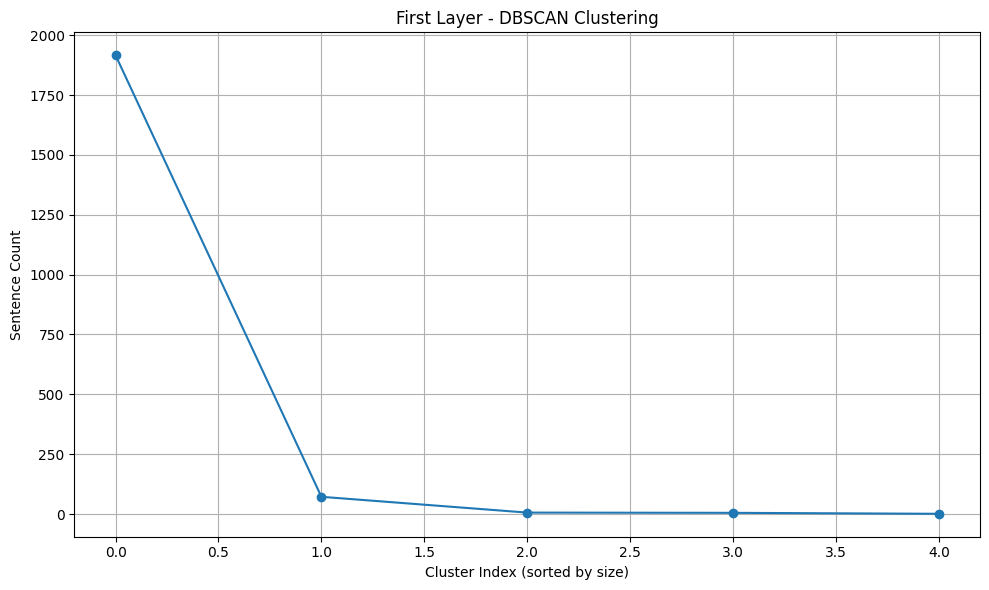

Saved plot: cluster_plots/middle_dbscan_book.png


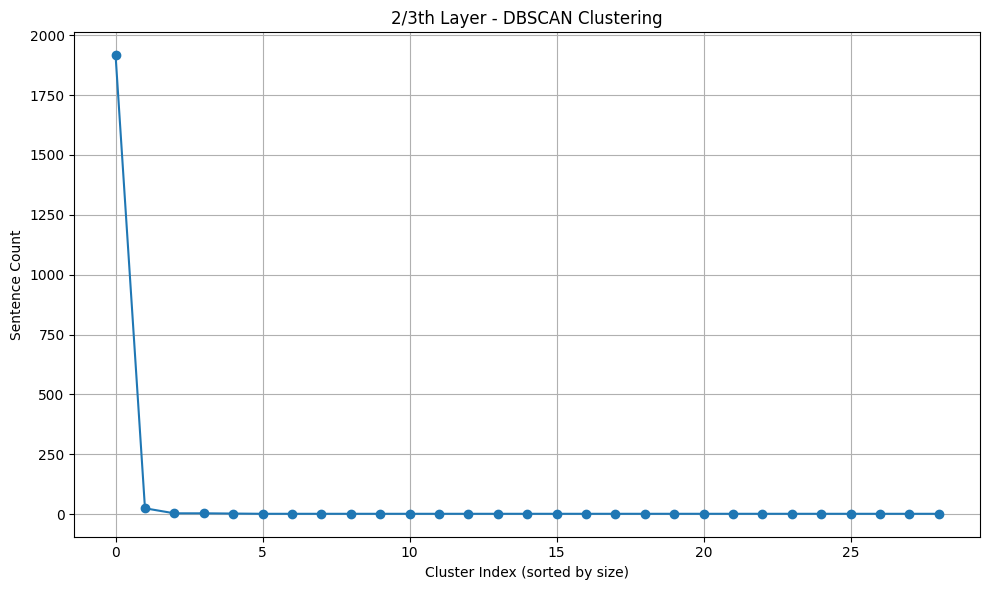

Saved plot: cluster_plots/last_dbscan_book.png


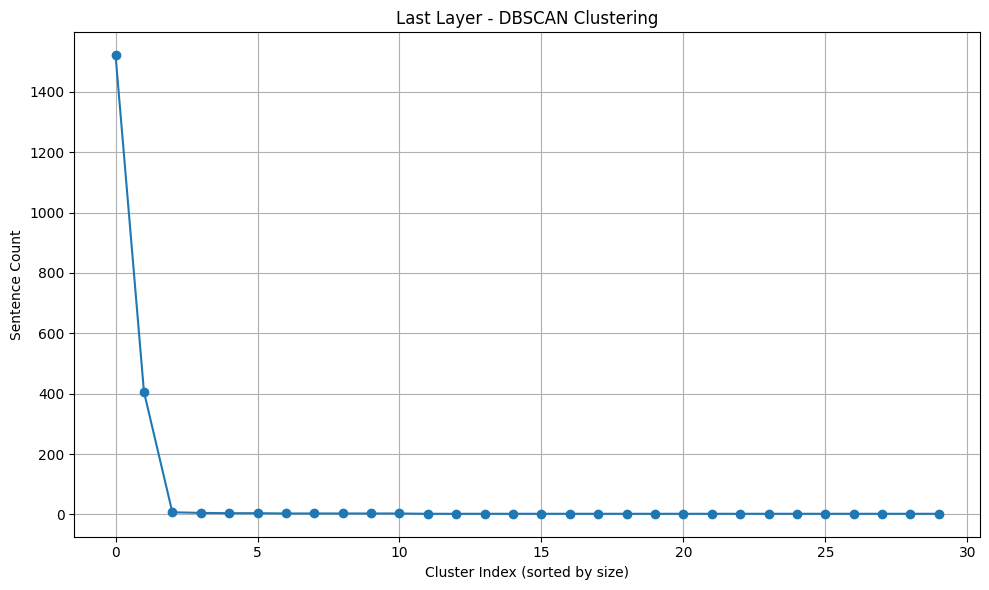

Saved plot: cluster_plots/first_kmeans_book.png


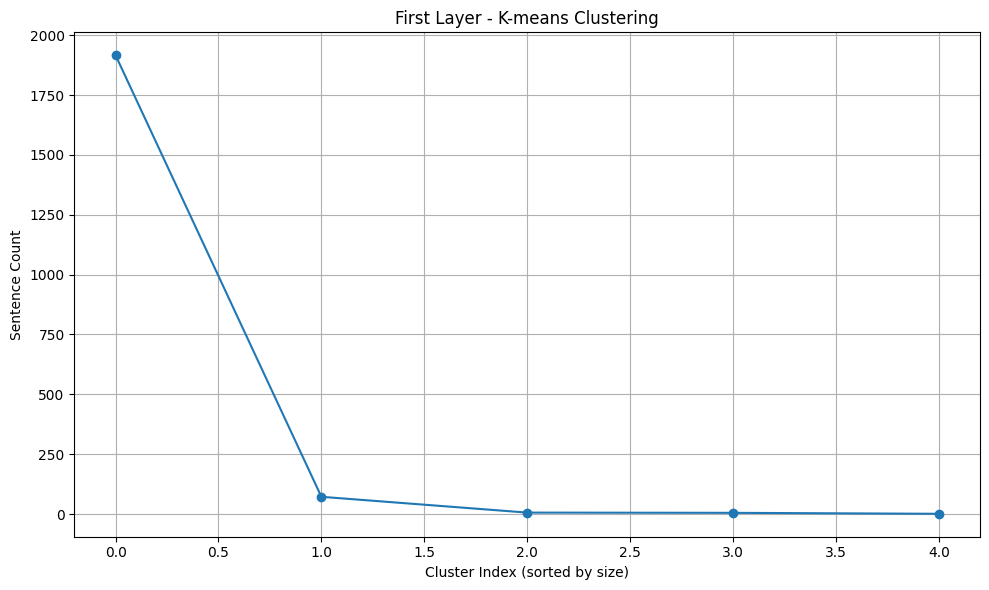

Saved plot: cluster_plots/middle_kmeans_book.png


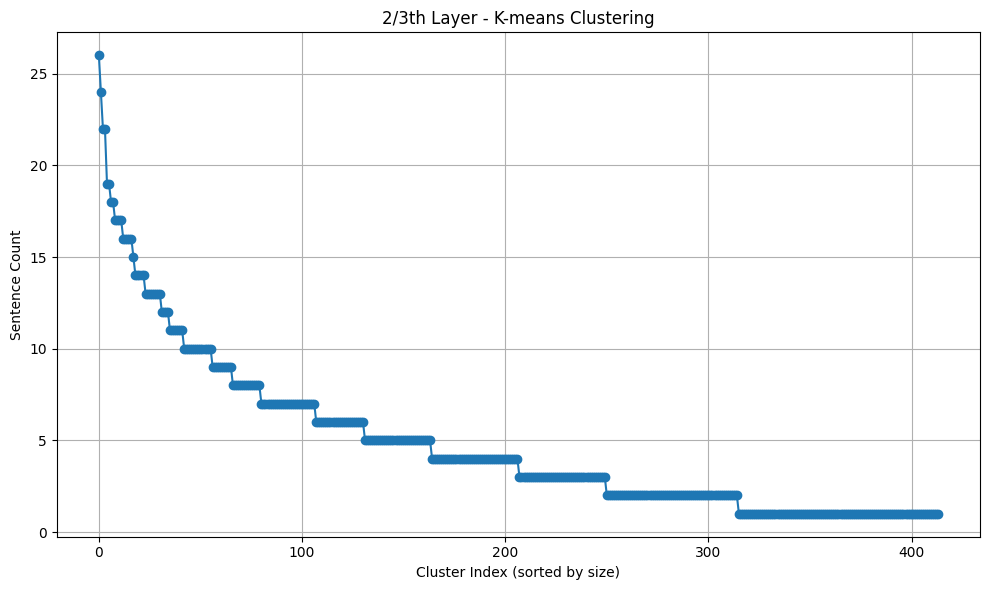

Saved plot: cluster_plots/last_kmeans_book.png


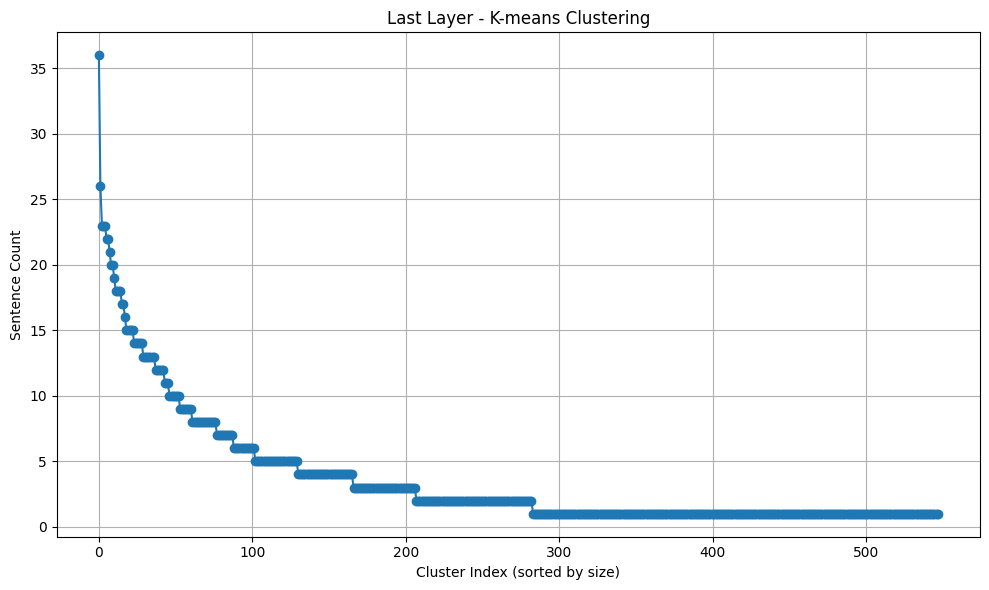

Saved plot: cluster_plots/first_cosine_book.png


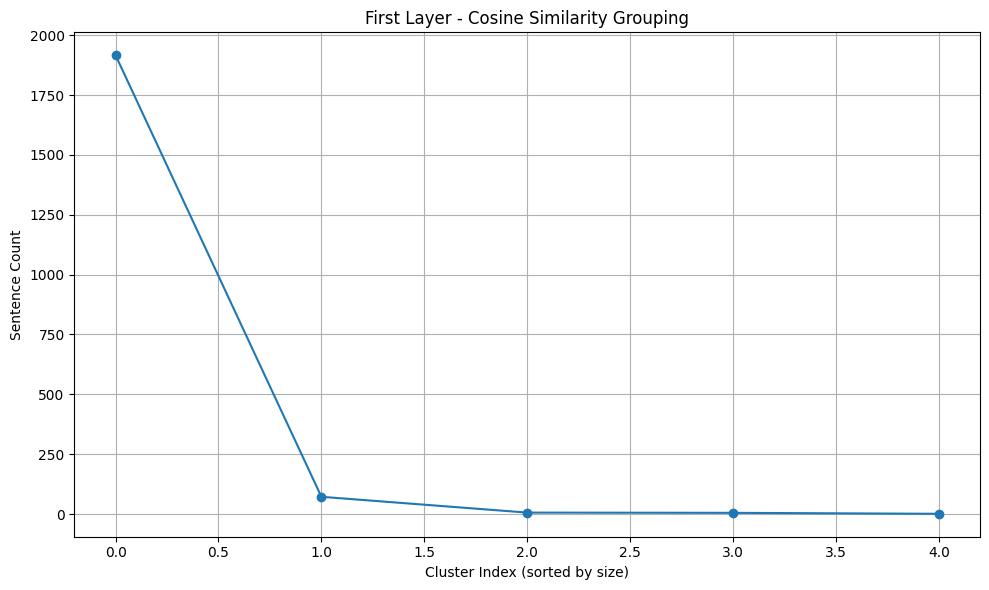

Saved plot: cluster_plots/middle_cosine_book.png


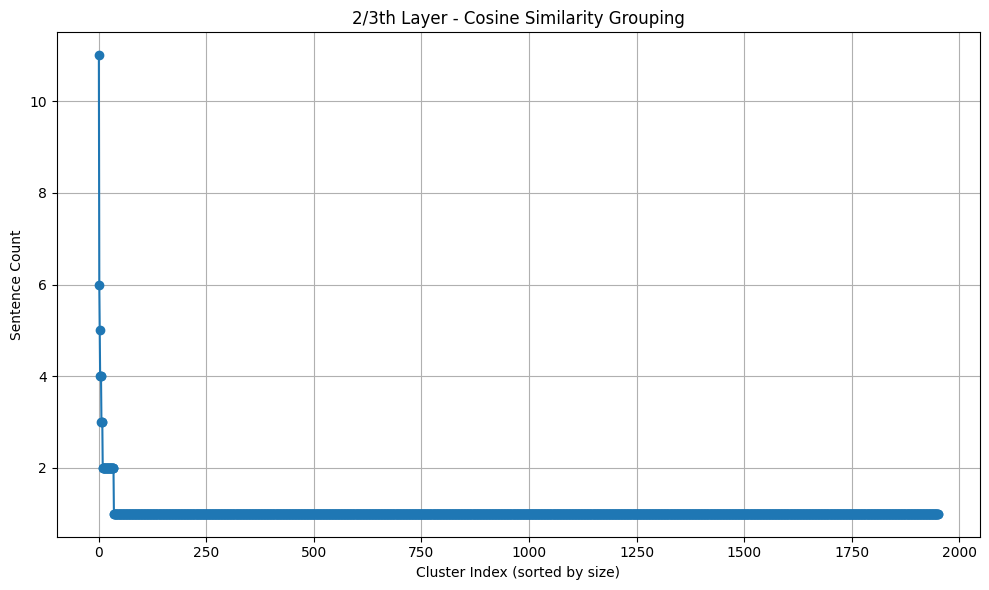

Saved plot: cluster_plots/last_cosine_book.png


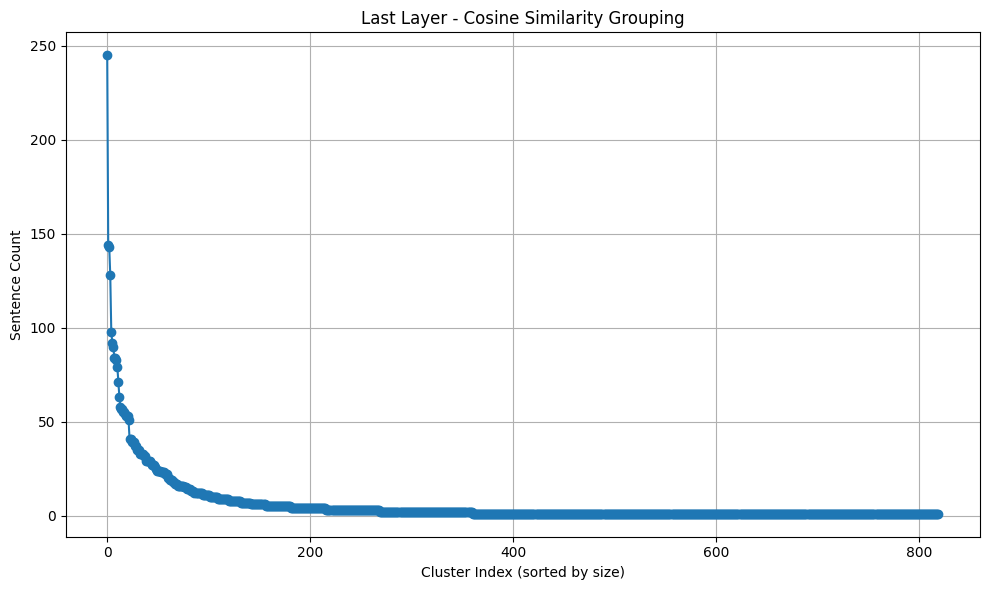

Saved plot: cluster_plots/first_graph_book.png


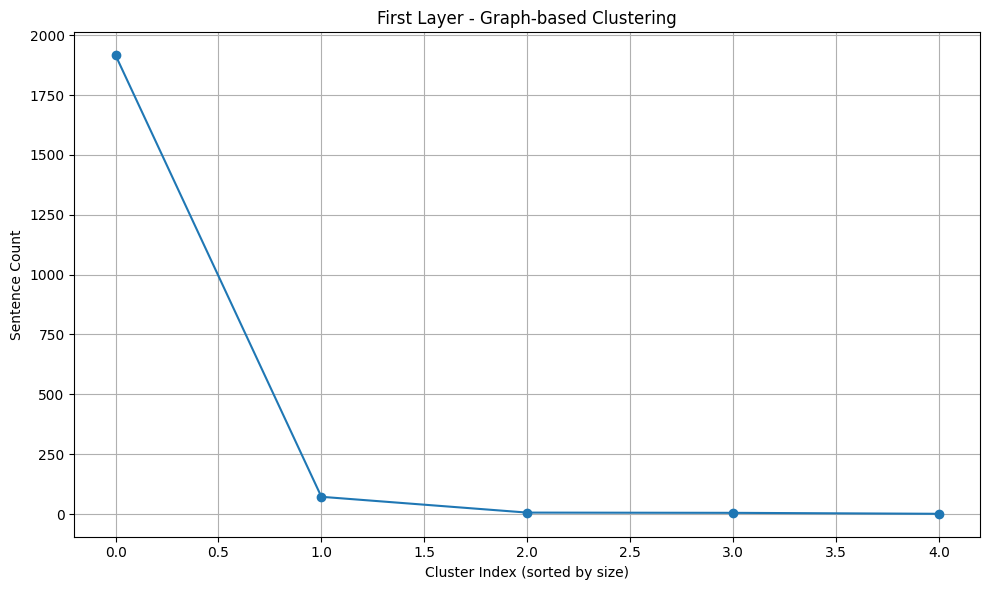

Saved plot: cluster_plots/middle_graph_book.png


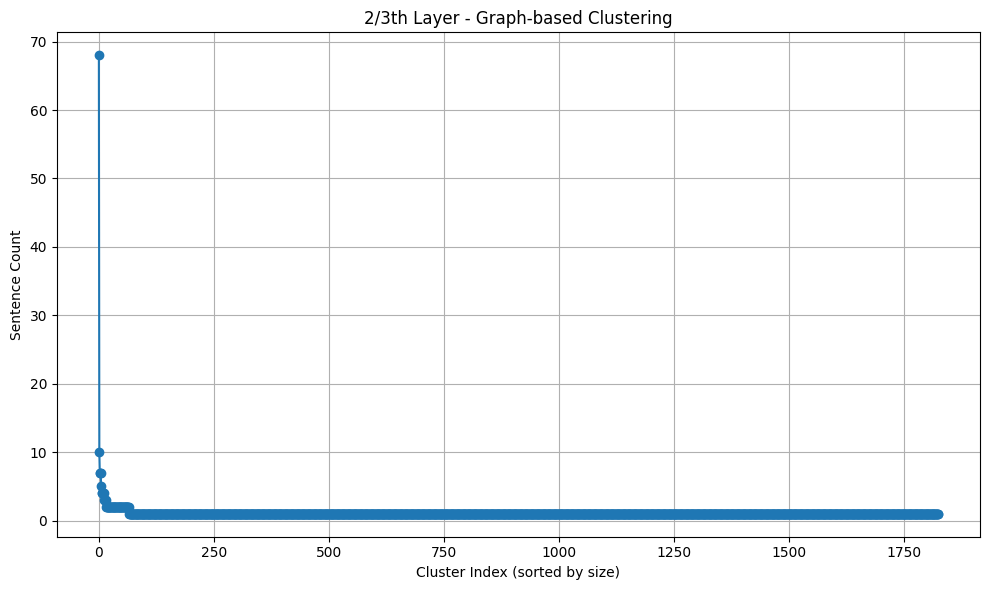

Saved plot: cluster_plots/last_graph_book.png


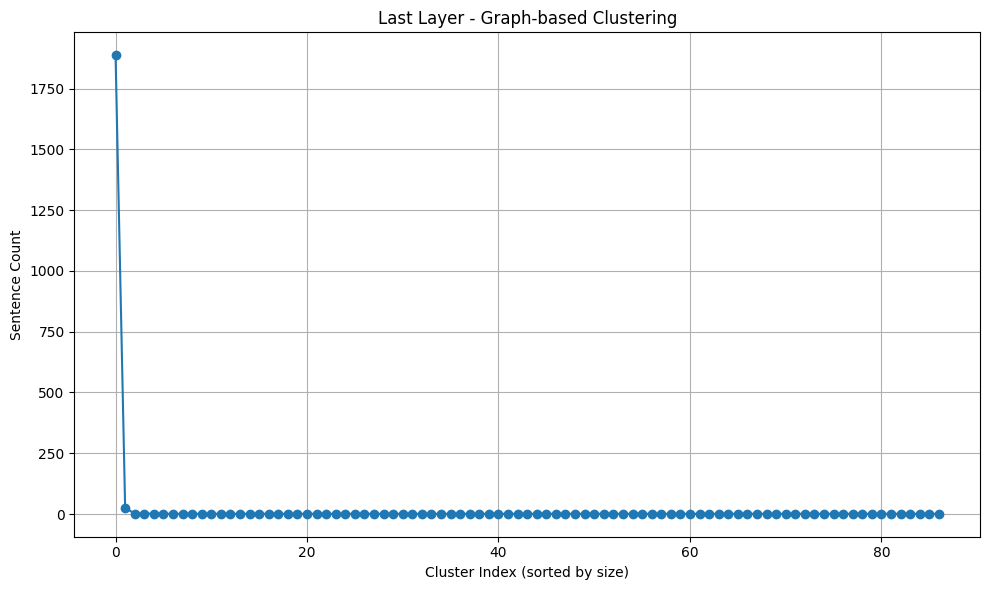

Saved plot: cluster_plots/first_hdbscan_book.png


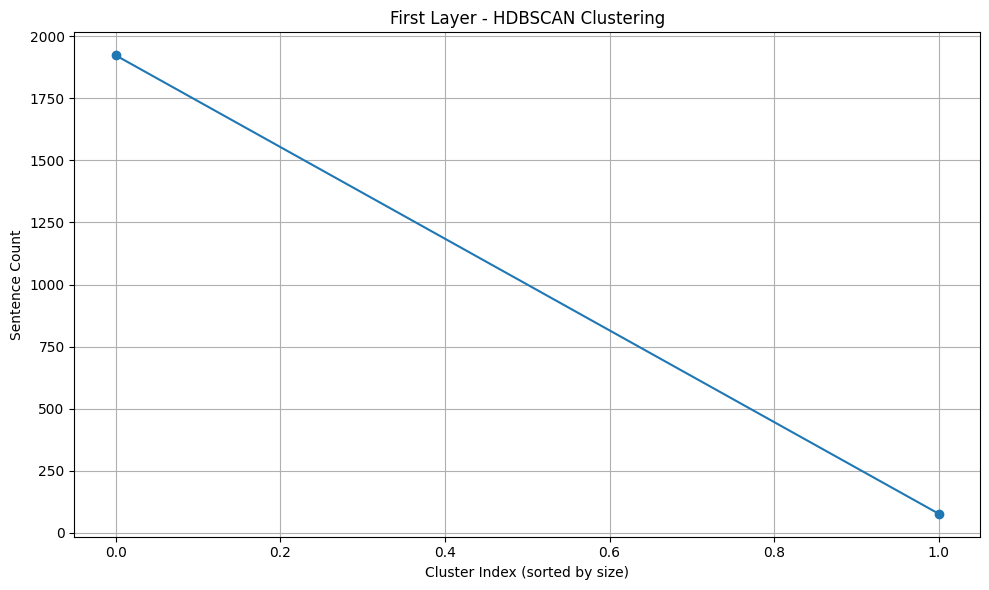

Saved plot: cluster_plots/middle_hdbscan_book.png


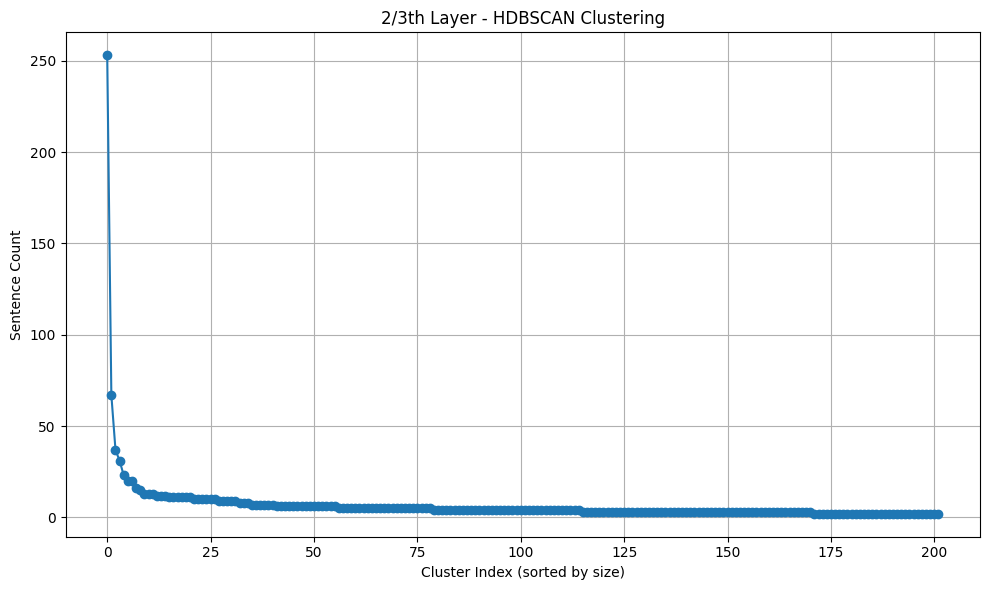

Saved plot: cluster_plots/last_hdbscan_book.png


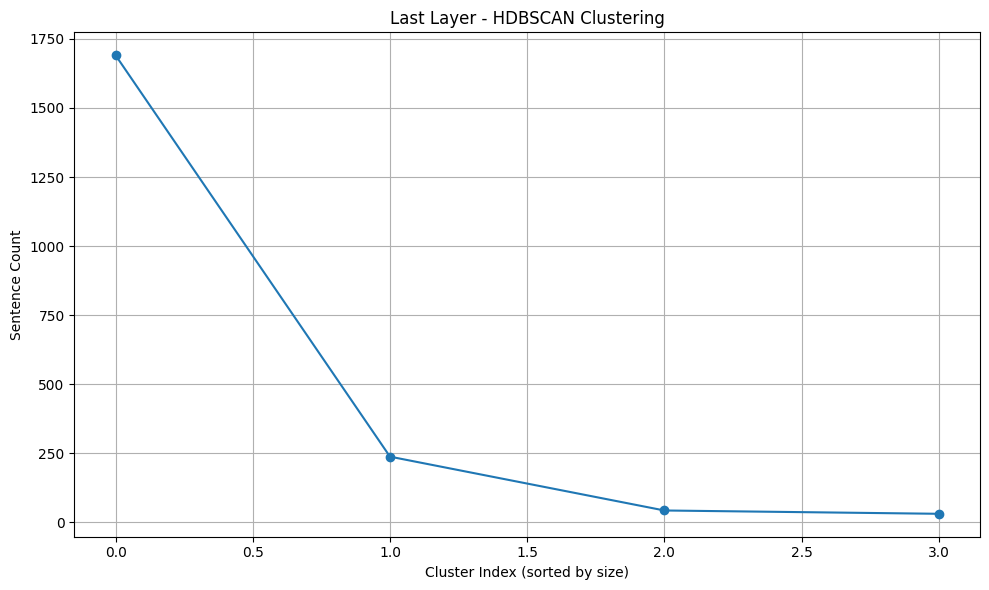

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

os.makedirs("cluster_plots", exist_ok=True)

vectors = [
    (vector_sent_dbscan_first, "First Layer - DBSCAN Clustering", "first", "dbscan"),
    (vector_sent_dbscan_middle, "2/3th Layer - DBSCAN Clustering", "middle", "dbscan"),
    (vector_sent_dbscan_last, "Last Layer - DBSCAN Clustering", "last", "dbscan"),

    (vector_sent_kmeans_first, "First Layer - K-means Clustering", "first", "kmeans"),
    (vector_sent_kmeans_mid, "2/3th Layer - K-means Clustering", "middle", "kmeans"),
    (vector_sent_kmeans_last, "Last Layer - K-means Clustering", "last", "kmeans"),

    (vector_sent_grouping_first, "First Layer - Cosine Similarity Grouping", "first", "cosine"),
    (vector_sent_grouping_middle, "2/3th Layer - Cosine Similarity Grouping", "middle", "cosine"),
    (vector_sent_grouping_last, "Last Layer - Cosine Similarity Grouping", "last", "cosine"),

    (vector_sent_graph_first, "First Layer - Graph-based Clustering", "first", "graph"),
    (vector_sent_graph_middle, "2/3th Layer - Graph-based Clustering", "middle", "graph"),
    (vector_sent_graph_last, "Last Layer - Graph-based Clustering", "last", "graph"),

    (vector_sent_hdbscan_layer0, "First Layer - HDBSCAN Clustering", "first", "hdbscan"),
    (vector_sent_hdbscan_layer14, "2/3th Layer - HDBSCAN Clustering", "middle", "hdbscan"),
    (vector_sent_hdbscan_layer22, "Last Layer - HDBSCAN Clustering", "last", "hdbscan")
]

for vector, title, layer_name, method_name in vectors:
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(vector)), sorted(vector, reverse=True), marker='o')
    plt.title(title)
    plt.xlabel('Cluster Index (sorted by size)')
    plt.ylabel('Sentence Count')
    plt.grid(True)
    plt.tight_layout()

    filename = f"cluster_plots/{layer_name}_{method_name}_book.png"
    plt.savefig(filename)
    print(f"Saved plot: {filename}")
    plt.show()  # also display


In [ ]:
import shutil
shutil.make_archive('/content/cluster_plots', 'zip', 'cluster_plots')
from google.colab import files
files.download('cluster_plots.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Summary of Power Law Regression Results:
Method                         Layer           Slope      R²         p-value   
--------------------------------------------------------------------------------
Saved: loglog_plots/loglog_first_dbscan_book.png


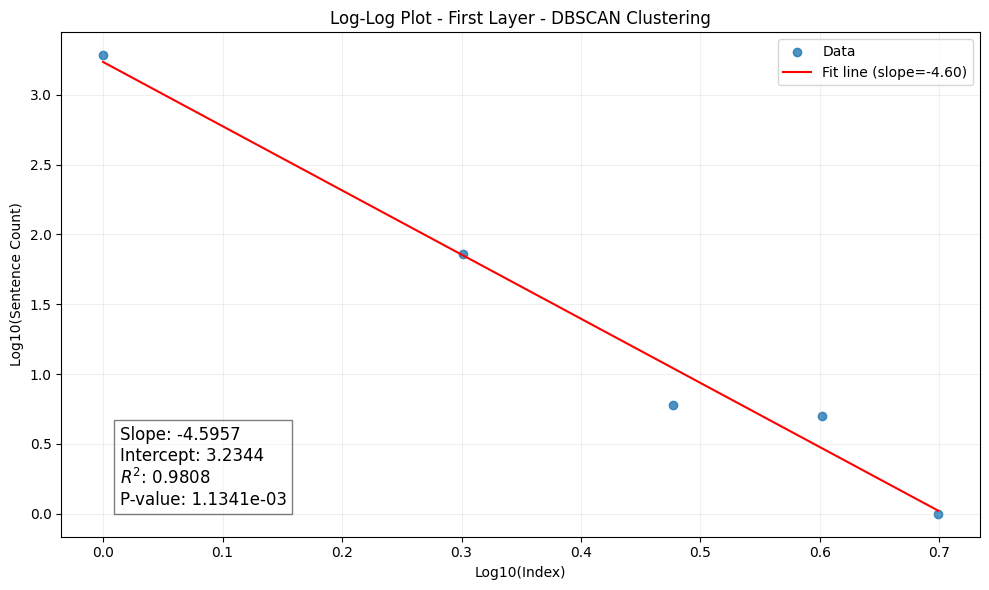

DBSCAN Clustering              First Layer     -4.5957    0.9808    1.1341e-03
Saved: loglog_plots/loglog_middle_dbscan_book.png


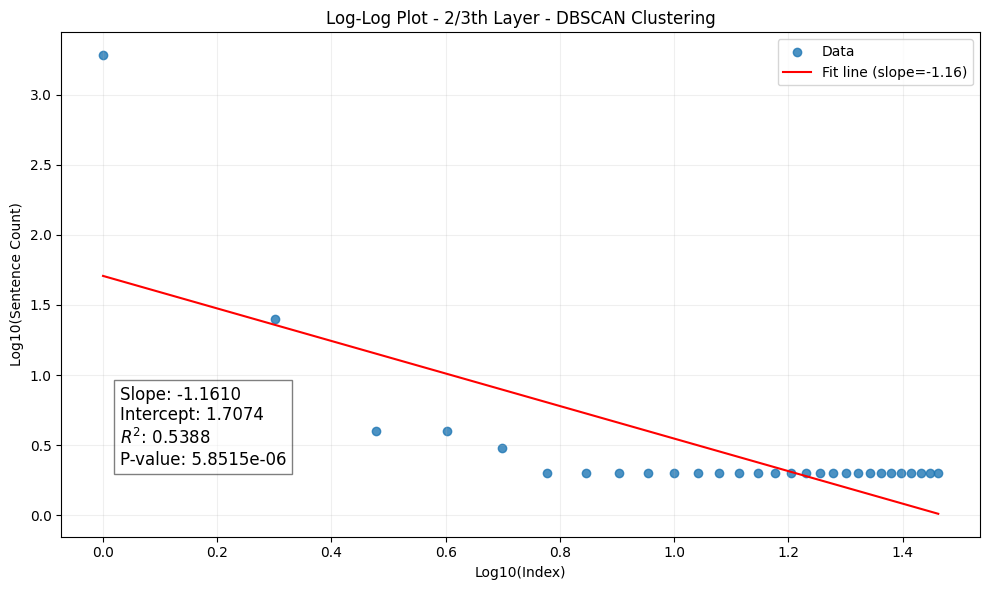

DBSCAN Clustering              2/3th Layer     -1.1610    0.5388    5.8515e-06
Saved: loglog_plots/loglog_last_dbscan_book.png


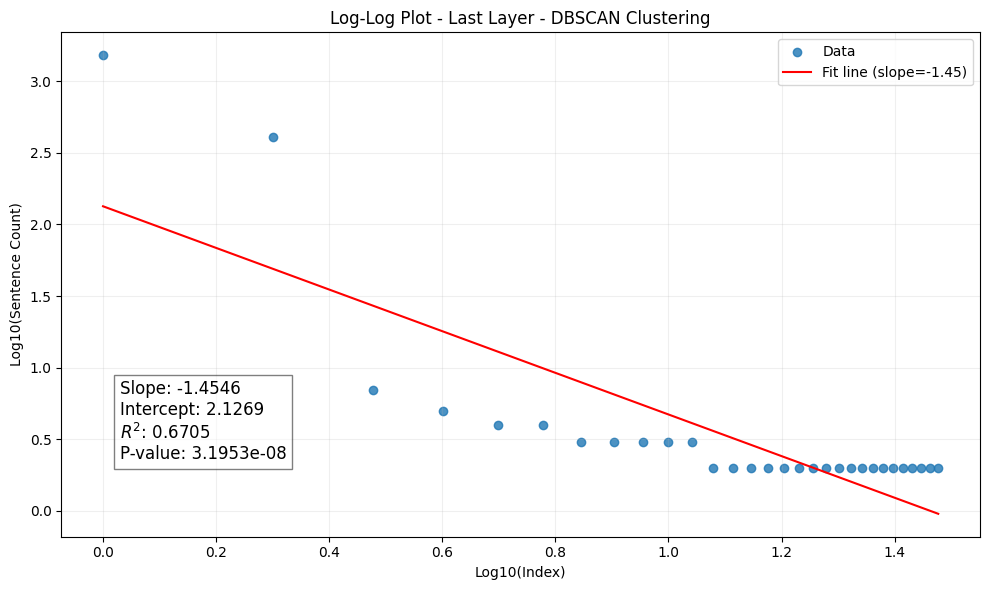

DBSCAN Clustering              Last Layer      -1.4546    0.6705    3.1953e-08
Saved: loglog_plots/loglog_first_kmeans_book.png


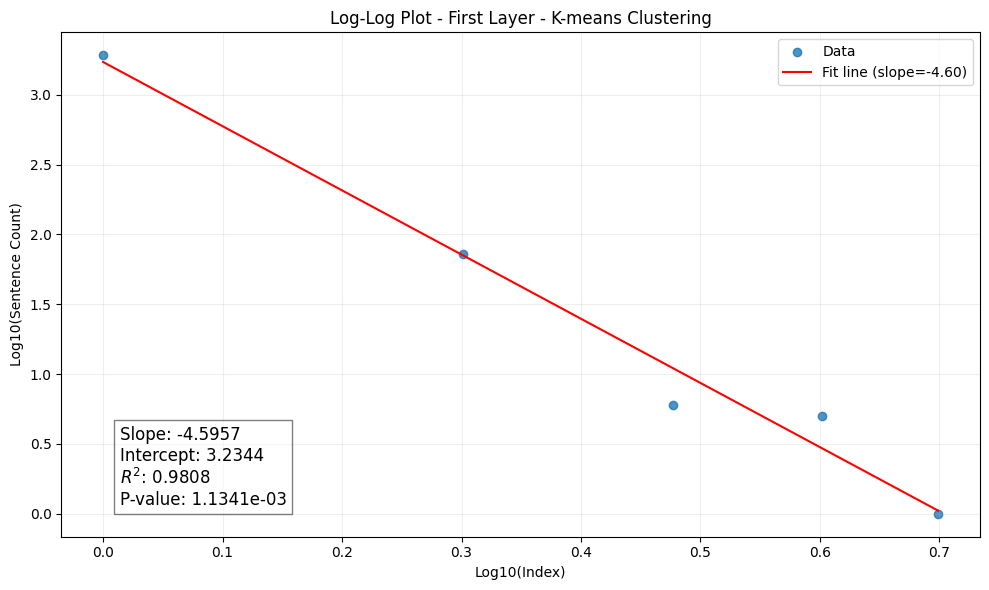

K-means Clustering             First Layer     -4.5957    0.9808    1.1341e-03
Saved: loglog_plots/loglog_middle_kmeans_book.png


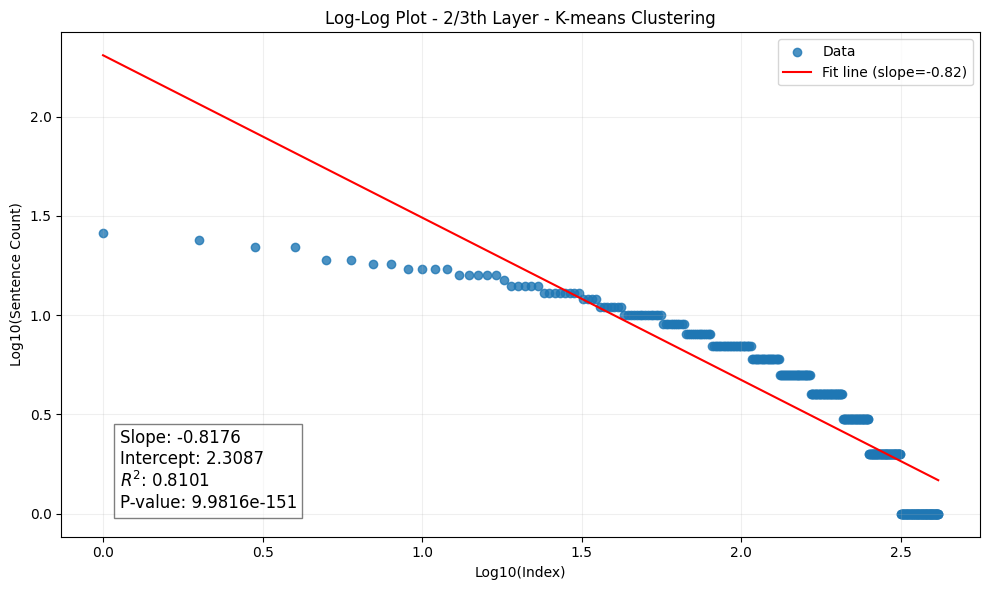

K-means Clustering             2/3th Layer     -0.8176    0.8101    9.9816e-151
Saved: loglog_plots/loglog_last_kmeans_book.png


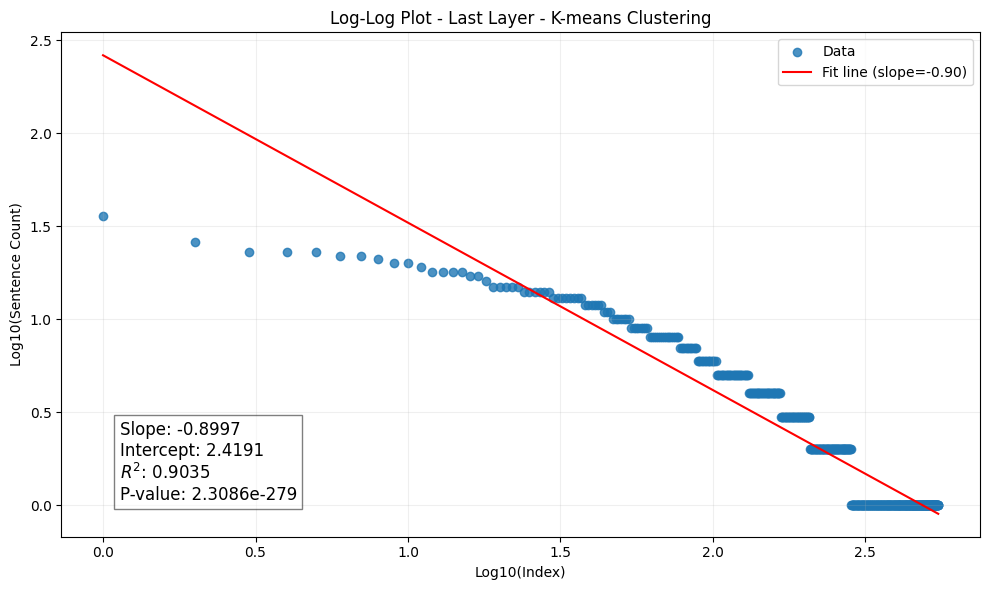

K-means Clustering             Last Layer      -0.8997    0.9035    2.3086e-279
Saved: loglog_plots/loglog_first_cosine_book.png


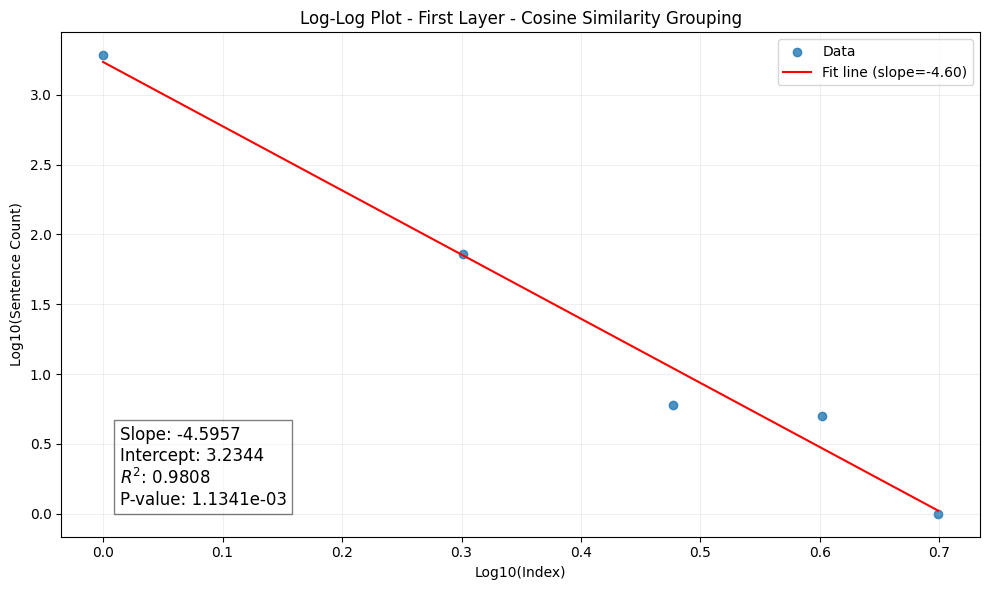

Cosine Similarity Grouping     First Layer     -4.5957    0.9808    1.1341e-03
Saved: loglog_plots/loglog_middle_cosine_book.png


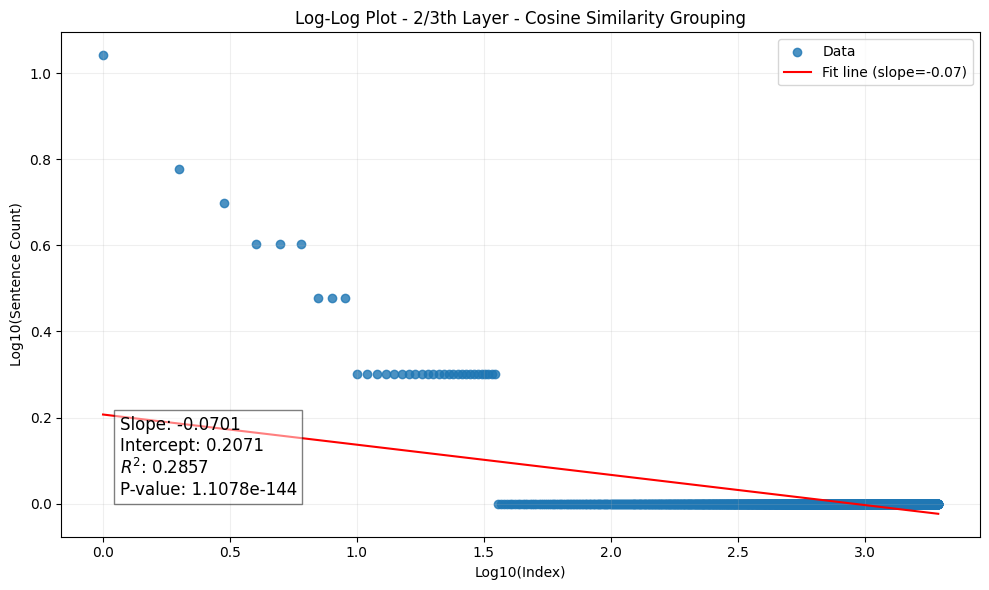

Cosine Similarity Grouping     2/3th Layer     -0.0701    0.2857    1.1078e-144
Saved: loglog_plots/loglog_last_cosine_book.png


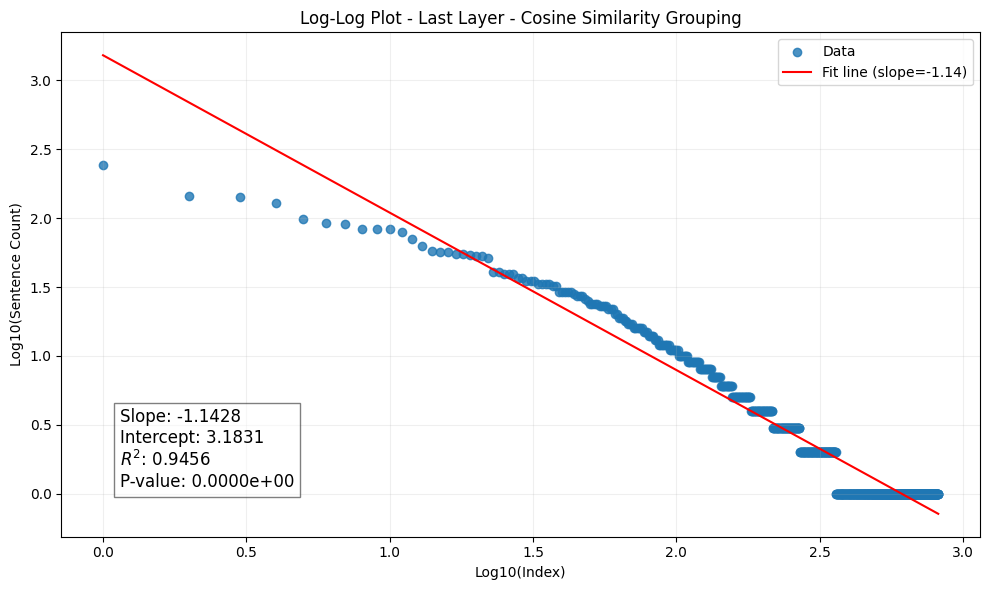

Cosine Similarity Grouping     Last Layer      -1.1428    0.9456    0.0000e+00
Saved: loglog_plots/loglog_first_graph_book.png


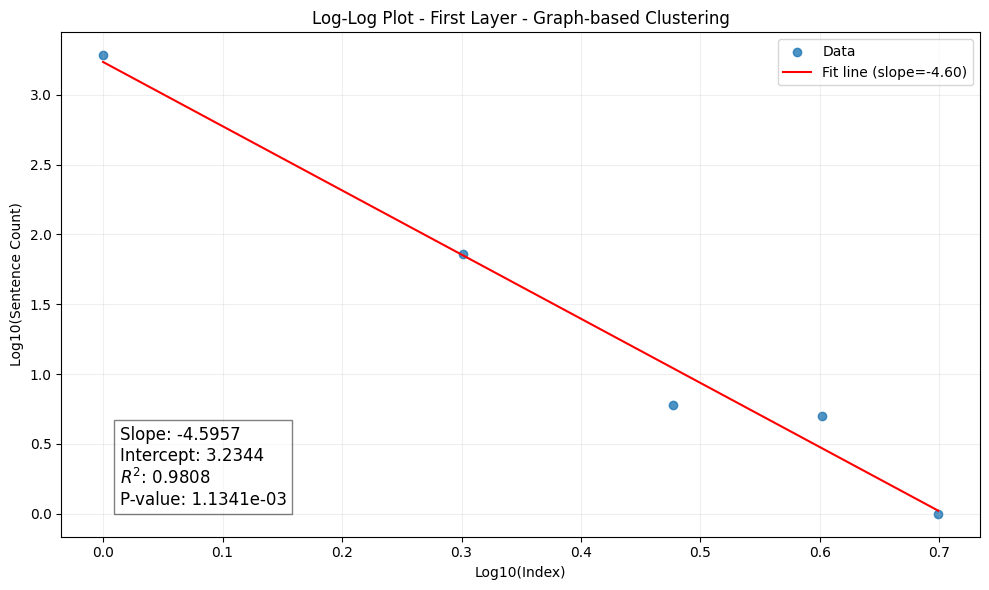

Graph-based Clustering         First Layer     -4.5957    0.9808    1.1341e-03
Saved: loglog_plots/loglog_middle_graph_book.png


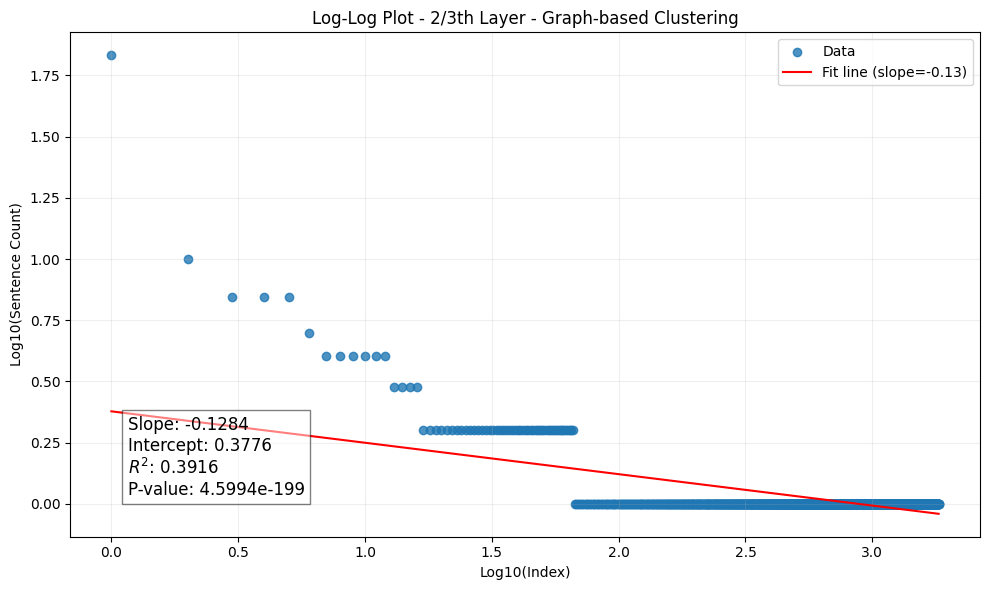

Graph-based Clustering         2/3th Layer     -0.1284    0.3916    4.5994e-199
Saved: loglog_plots/loglog_last_graph_book.png


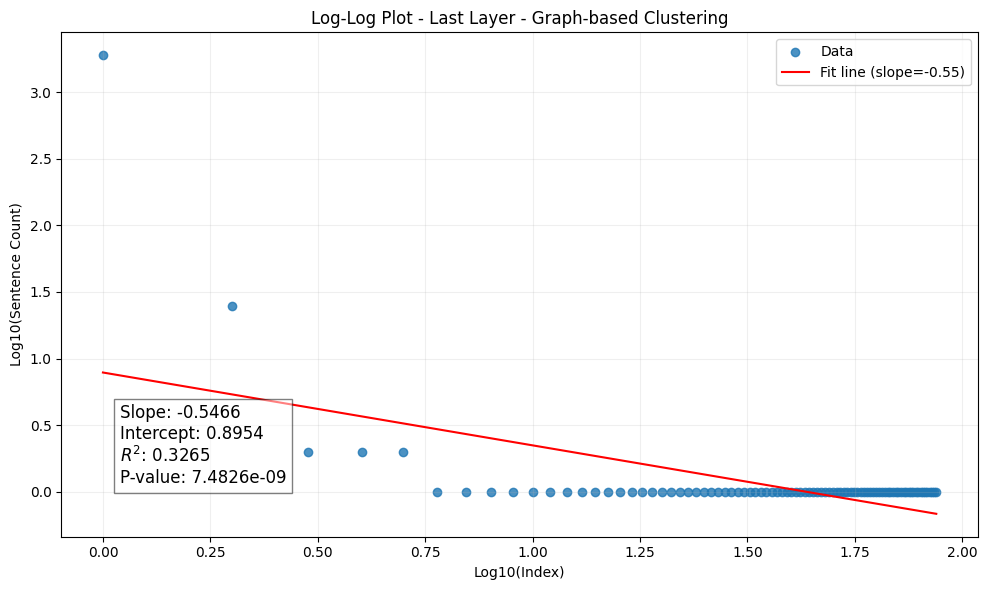

Graph-based Clustering         Last Layer      -0.5466    0.3265    7.4826e-09
Saved: loglog_plots/loglog_first_hdbscan_book.png


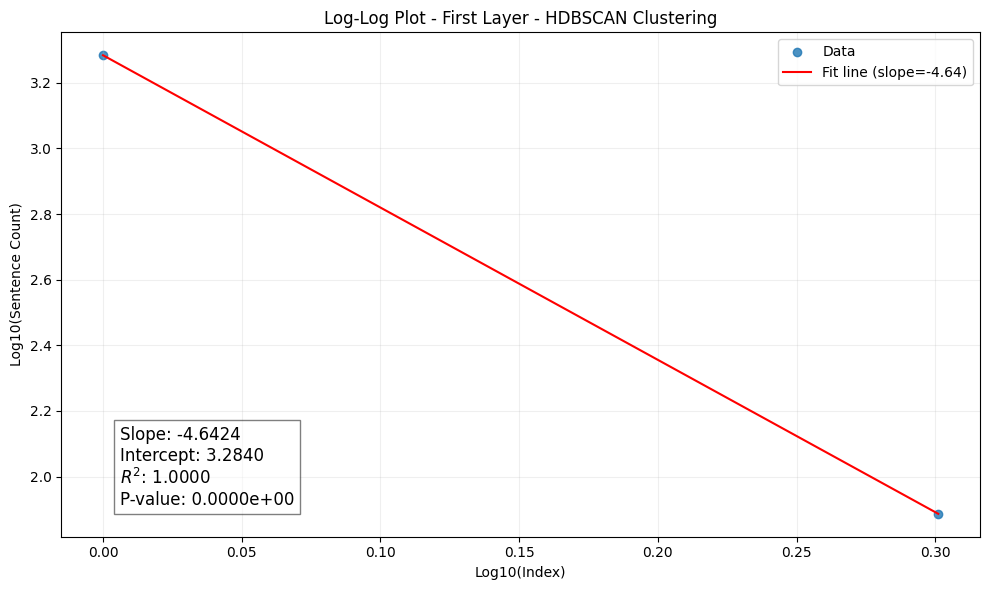

HDBSCAN Clustering             First Layer     -4.6424    1.0000    0.0000e+00
Saved: loglog_plots/loglog_middle_hdbscan_book.png


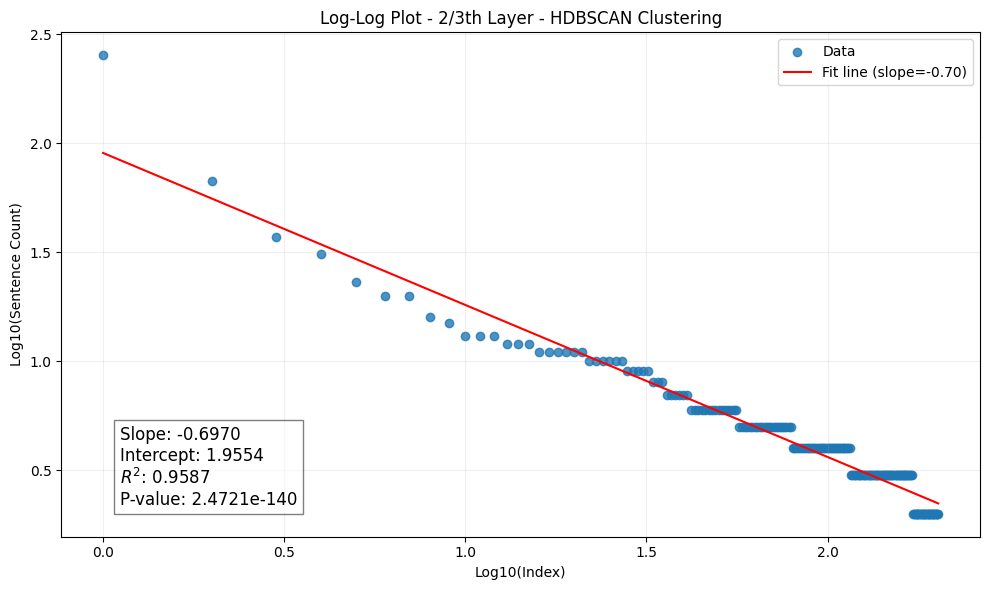

HDBSCAN Clustering             2/3th Layer     -0.6970    0.9587    2.4721e-140
Saved: loglog_plots/loglog_last_hdbscan_book.png


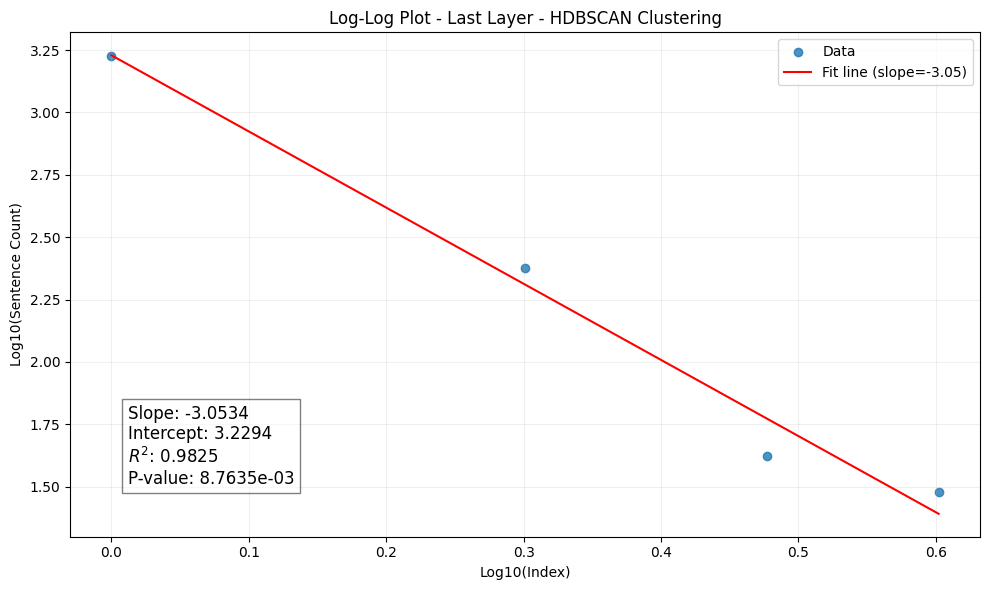

HDBSCAN Clustering             Last Layer      -3.0534    0.9825    8.7635e-03


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import os

os.makedirs("loglog_plots", exist_ok=True)

def linear_regression(counts):
    valid_counts = counts[counts > 0]
    if len(valid_counts) <= 1:
        return None, None, 0, 0, 0, 1, None
    x = np.log10(np.arange(1, len(valid_counts)+1))
    y = np.log10(valid_counts)
    slope, intercept, r_val, p_val, std_err = linregress(x, y)
    y_pred = slope * x + intercept
    return x, y, slope, intercept, r_val, p_val, y_pred


vectors = [
    (vector_sent_dbscan_first, "First Layer - DBSCAN Clustering", "first", "dbscan"),
    (vector_sent_dbscan_middle, "2/3th Layer - DBSCAN Clustering", "middle", "dbscan"),
    (vector_sent_dbscan_last, "Last Layer - DBSCAN Clustering", "last", "dbscan"),

    (vector_sent_kmeans_first, "First Layer - K-means Clustering", "first", "kmeans"),
    (vector_sent_kmeans_mid, "2/3th Layer - K-means Clustering", "middle", "kmeans"),
    (vector_sent_kmeans_last, "Last Layer - K-means Clustering", "last", "kmeans"),

    (vector_sent_grouping_first, "First Layer - Cosine Similarity Grouping", "first", "cosine"),
    (vector_sent_grouping_middle, "2/3th Layer - Cosine Similarity Grouping", "middle", "cosine"),
    (vector_sent_grouping_last, "Last Layer - Cosine Similarity Grouping", "last", "cosine"),

    (vector_sent_graph_first, "First Layer - Graph-based Clustering", "first", "graph"),
    (vector_sent_graph_middle, "2/3th Layer - Graph-based Clustering", "middle", "graph"),
    (vector_sent_graph_last, "Last Layer - Graph-based Clustering", "last", "graph"),

    (vector_sent_hdbscan_layer0, "First Layer - HDBSCAN Clustering", "first", "hdbscan"),
    (vector_sent_hdbscan_layer14, "2/3th Layer - HDBSCAN Clustering", "middle", "hdbscan"),
    (vector_sent_hdbscan_layer22, "Last Layer - HDBSCAN Clustering", "last", "hdbscan")
]

print("\nSummary of Power Law Regression Results:")
print("=" * 80)
print(f"{'Method':<30} {'Layer':<15} {'Slope':<10} {'R²':<10} {'p-value':<10}")
print("-" * 80)

for vector, title, layer_key, method_key in vectors:
    x, y, slope, intercept, r_val, p_val, y_pred = linear_regression(np.array(vector))
    if x is None:
        print(f"Regression failed for {title} - not enough valid data points")
        continue

    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, alpha=0.8, label='Data')
    plt.plot(x, y_pred, 'r-', label=f'Fit line (slope={slope:.2f})')
    plt.title(f"Log-Log Plot - {title}")
    plt.xlabel('Log10(Index)')
    plt.ylabel('Log10(Sentence Count)')
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend()

    text_x = min(x) + (max(x) - min(x)) * 0.02
    text_y = min(y) + (max(y) - min(y)) * 0.02
    plt.text(text_x, text_y,
             f"Slope: {slope:.4f}\nIntercept: {intercept:.4f}\n$R^2$: {r_val**2:.4f}\nP-value: {p_val:.4e}",
             fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    plt.tight_layout()

    filename = f"loglog_plots/loglog_{layer_key}_{method_key}_book.png"
    plt.savefig(filename)
    print(f"Saved: {filename}")
    plt.show()

    method = title.split(" - ")[1]
    layer = title.split(" - ")[0]
    print(f"{method:<30} {layer:<15} {slope:.4f}    {r_val**2:.4f}    {p_val:.4e}")


In [ ]:
import shutil
shutil.make_archive('/content/loglog_plots', 'zip', 'loglog_plots')
from google.colab import files
files.download('loglog_plots.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>